In [1]:
"""
from google.colab import drive
drive.mount('/content/gdrive/')

#!pip install -q condacolab
#import condacolab
#condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision
"""

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive/')\n\n#!pip install -q condacolab\n#import condacolab\n#condacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision\n"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/z/home/sgal/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16

    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction

    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/BLAT500_gaps.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/BLAT500_alignment.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta


    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case')
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report')
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization')
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=1750, help='number of tesselation cells') #6 80, the increasing of tess improve the performance when there are more samples to train the density estimator
    cpab.add_argument('--channels', type=int, default=1750, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps')

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=60, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')


    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] 
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_23_preprint_22feb2024.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)


'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=100)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


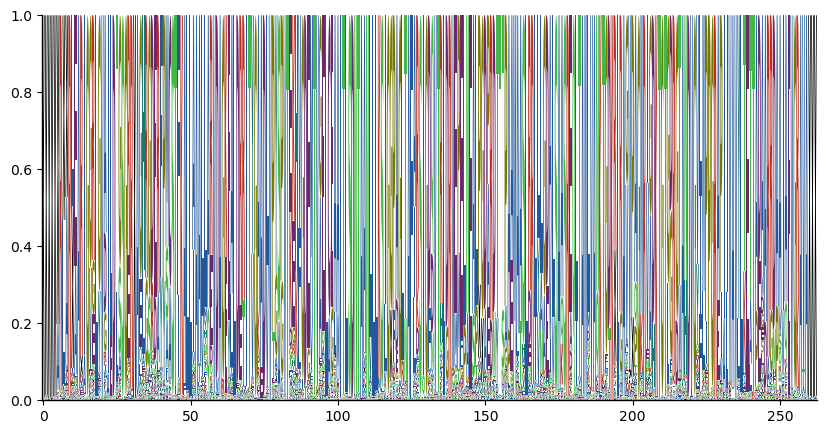

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.01)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")

else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 1000, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )


deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)

In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])

    #fig.tight_layout()


def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt

    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize) #; fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet]
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)

        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)

    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')

    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()

def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''

        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))

        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs),
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)

                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]


                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS
                optimizer.step()


                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())

                # Save to tensorboard
                iteration = epoch*len(trainloader) + i

                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()

        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_23_preprint_23feb2024_batchsize_100.pth'
pretrained_density = logdir_density + "/" + outmodel_name_density
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std,
                    latent_dim = args.latent_dim,
                    encoder = get_encoder( args.ed_type.split(",")[0] ),
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-575,575])#[-175,175] [-15,15] ) #[15,15] #if we increase it, major accuracy

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-5)#, weight_decay=1e-19)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'


if os.path.isfile(pretrained_density):
    print ("Loading Density Model...")
    model.load_state_dict( torch.load(pretrained_density, map_location=casted_device) )
    print ("Loaded")
else:
    fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=400, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # initi
    
    torch.save(model.state_dict(), pretrained_density)




Loading Density Model...
Loaded


In [10]:

def get_elbos(model, set, aux=None):
    import torch.nn.functional as F
    model.eval()


    idx_recon = 0
    #loss_function = LossFunctionsAlternatives()
    loss_function = torch.nn.CrossEntropyLoss(reduction='mean')
    #loss_function = F.cross_entropy
    #            self.component_vals = self.Cross_Entropy(input.permute(forw_per), target.argmax(-1))
    #        self.loss= self.component_vals.sum(dim=-1).mean()
    if model.__class__.__name__=='DeepSequence': idx_kls = 5
    else: idx_kls = 7
    
    with torch.no_grad():
        acc_m_elbo = 0
        acc_wt_elbo = 0
        
        wt = set[0,:,:].unsqueeze(0)
        mutants = set[1:,:,:]
        
        if aux==None:
            results_wt = model(wt)
            results_mutants = model(mutants)
            log_p_mutant = loss_function(results_mutants[idx_recon].permute(0,2,1), mutants.argmax(-1))
            log_p_wt     = loss_function(results_wt[idx_recon].permute(0,2,1), wt.argmax(-1))
            elbo_wt      = log_p_wt - results_wt[idx_kls]
            elbo_mutants = log_p_mutant - results_mutants[idx_kls]
        else:
            results_wt = model(wt, aux, 1, 1, 1)
            log_p_wt     = loss_function(results_wt[0].permute(0,2,1), wt.argmax(-1))
            elbo_wt      = log_p_wt + results_wt[idx_kls]
            
            # Process the 500 sequences in batches of 100 sequences each
            mutants_batch = torch.split(mutants, 10)
            results_mutants = []; batch_log_p_mutants = []; batch_elbo_mutants = []
            #results_mutants = [ model(i,aux, 1, 1, 1) for i in tqdm(mutants_batch) ]
            for ii in tqdm(mutants_batch):
                res_tmp = model(ii,aux, 1, 1, 1)

                recon_tmp = loss_function(res_tmp[idx_recon].permute(0,2,1), ii.argmax(-1))
                
                results_mutants.append(res_tmp)
                batch_log_p_mutants.append( recon_tmp )
                batch_elbo_mutants.append( recon_tmp +  res_tmp[idx_kls] )


            log_p_mutant = torch.mean( torch.tensor(batch_log_p_mutants) )
            elbo_mutants = torch.mean( torch.tensor(batch_elbo_mutants) )
            
                        
        delta_elbo = elbo_mutants - elbo_wt
        
    return {'log_p_mutant':log_p_mutant.cpu().item(), 'log_p_wt':log_p_wt.cpu().item(),
            'elbo_wt':elbo_wt.cpu().item(), 'elbo_mutants':elbo_mutants.cpu().item(),
            'delta_elbo':delta_elbo.cpu().item()}
    
def make_table_to_latex(Results_Table):
    
    latex_out = Results_Table.to_latex(
        column_format='cccccc',  # Custom column alignment
        header=True,                # Include column names
        index=True,                 # Include row indexes
        index_names=True,           # Include index names
        bold_rows=True,             # Bold first level of row labels
        float_format="%.2f",        # Format floating-point numbers
        na_rep="-"                  # Replace missing values with "-"
    )

    latex_out = latex_out.replace('\\toprule','\\hline\\hline')
    latex_out = latex_out.replace('\\midrule','\\hline\\hline')
    latex_out = latex_out.replace('\\bottomrule','\\hline\\hline')

    with open( output_results_test5, 'w') as f:
        f.write(latex_out)

def ELBO_MultipleSampling_experiment( model, set, iter=10, aux=None ):
    
    res_samples =[]

    if aux==None:
        for i in range(0,iter):
            print('Sampling #{}'.format(i))
            res_samples.append(
                               get_elbos(model, set, aux=None)
                               )
    
    else:
        for i in range(0,iter):
            print('Sampling #{}'.format(i))
            res_samples.append(
                               get_elbos(model, set, aux=aux)
                               )
            
    df_bulk_res = pd.DataFrame(res_samples)
    
    return {'log_p_mutant':df_bulk_res.log_p_mutant.mean().item(), 
            'log_p_wt':df_bulk_res.log_p_wt.mean().item(),
            'elbo_wt':df_bulk_res.elbo_wt.mean().item(), 
            'elbo_mutants':df_bulk_res.elbo_mutants.mean().item(),
            'delta_elbo':df_bulk_res.delta_elbo.mean().item()}
    
        

output_results_test5 = 'Final_Results_test5.tex'

subset = dataset_msa.prot_space#[0:4, :, :]
subset_msa = dataset_aligned_msa.prot_space#[0:500, :, :]


import pprint
res_DeepSeq = get_elbos(deepseq, subset_msa, aux=None)
res_PGM = get_elbos(model, subset, aux=deepseq)
res_DeepSeq_sampling = ELBO_MultipleSampling_experiment( deepseq, subset, iter=200, aux=None )
res_PGM_sampling = ELBO_MultipleSampling_experiment( model, subset, iter=200, aux=deepseq )
pprint.pprint(res_DeepSeq)
pprint.pprint(res_PGM)
pprint.pprint(res_PGM_sampling)

Results_Table = pd.DataFrame([res_DeepSeq, res_PGM, res_DeepSeq_sampling, res_PGM_sampling], index=['DeepSequence', 'Our', 'DeepSequence_Sampling','Our_sampling']) 
make_table_to_latex(Results_Table)
print( Results_Table )


    
print('Done')


/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  4%|▍         | 2/50 [00:03<01:17,  1.61s/it]

  6%|▌         | 3/50 [00:04<01:19,  1.69s/it]

  8%|▊         | 4/50 [00:06<01:19,  1.74s/it]

 10%|█         | 5/50 [00:08<01:18,  1.74s/it]

 12%|█▏        | 6/50 [00:10<01:17,  1.77s/it]

 14%|█▍        | 7/50 [00:11<01:11,  1.67s/it]

 16%|█▌        | 8/50 [00:13<01:07,  1.62s/it]

 18%|█▊        | 9/50 [00:14<01:04,  1.58s/it]

 20%|██        | 10/50 [00:16<01:02,  1.56s/it]

 22%|██▏       | 11/50 [00:17<00:59,  1.52s/it]

 24%|██▍       | 12/50 [00:19<00:56,  1.49s/it]

 26%|██▌       | 13/50 [00:20<00:54,  1.48s/it]

 28%|██▊       | 14/50 [00:22<00:52,  1.46s/it]

 30%|███       | 15/50 [00:23<00:50,  1.45s/it]

 32%|███▏      | 16/50 [00:24<00:48,  1.44s/it]

 34%|███▍      | 17/50 [00:26<00:47,  1.45s/it]

 36%|███▌      | 18/50 [00:27<00:46,  1.46s/it]

 38%|███▊      | 19/50 [00:29<00:45,  1.46s/it]

 40%|████      | 20/50 [00:30<00:44,  1.48s/it]

 42%|████▏     | 21/50 [00:32<00:42,  1.48s/it]

 44%|████▍     | 22/50 [00:33<00:40,  1.46s/it]

 46%|████▌     | 23/50 [00:35<00:39,  1.45s/it]

 48%|████▊     | 24/50 [00:36<00:37,  1.43s/it]

 50%|█████     | 25/50 [00:37<00:35,  1.43s/it]

 52%|█████▏    | 26/50 [00:39<00:34,  1.42s/it]

 54%|█████▍    | 27/50 [00:40<00:32,  1.42s/it]

 56%|█████▌    | 28/50 [00:42<00:31,  1.42s/it]

 58%|█████▊    | 29/50 [00:43<00:29,  1.42s/it]

 60%|██████    | 30/50 [00:45<00:28,  1.43s/it]

 62%|██████▏   | 31/50 [00:46<00:27,  1.45s/it]

 64%|██████▍   | 32/50 [00:47<00:25,  1.43s/it]

 66%|██████▌   | 33/50 [00:49<00:24,  1.43s/it]

 68%|██████▊   | 34/50 [00:50<00:22,  1.43s/it]

 70%|███████   | 35/50 [00:52<00:21,  1.43s/it]

 72%|███████▏  | 36/50 [00:53<00:19,  1.43s/it]

 74%|███████▍  | 37/50 [00:55<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:56<00:16,  1.41s/it]

 78%|███████▊  | 39/50 [00:57<00:15,  1.42s/it]

 80%|████████  | 40/50 [00:59<00:14,  1.42s/it]

 82%|████████▏ | 41/50 [01:00<00:12,  1.43s/it]

 84%|████████▍ | 42/50 [01:02<00:11,  1.42s/it]

 86%|████████▌ | 43/50 [01:03<00:09,  1.41s/it]

 88%|████████▊ | 44/50 [01:04<00:08,  1.40s/it]

 90%|█████████ | 45/50 [01:06<00:07,  1.43s/it]

 92%|█████████▏| 46/50 [01:07<00:05,  1.44s/it]

 94%|█████████▍| 47/50 [01:09<00:04,  1.43s/it]

 96%|█████████▌| 48/50 [01:10<00:02,  1.42s/it]

 98%|█████████▊| 49/50 [01:12<00:01,  1.42s/it]

100%|██████████| 50/50 [01:13<00:00,  1.40s/it]

100%|██████████| 50/50 [01:13<00:00,  1.47s/it]

Sampling #0
Sampling #1
Sampling #2
Sampling #3
Sampling #4
Sampling #5
Sampling #6
Sampling #7
Sampling #8
Sampling #9
Sampling #10
Sampling #11
Sampling #12
Sampling #13
Sampling #14
Sampling #15
Sampling #16
Sampling #17
Sampling #18
Sampling #19
Sampling #20
Sampling #21
Sampling #22
Sampling #23
Sampling #24
Sampling #25
Sampling #26
Sampling #27
Sampling #28
Sampling #29
Sampling #30
Sampling #31
Sampling #32
Sampling #33
Sampling #34
Sampling #35
Sampling #36
Sampling #37
Sampling #38
Sampling #39
Sampling #40
Sampling #41
Sampling #42
Sampling #43
Sampling #44
Sampling #45
Sampling #46
Sampling #47
Sampling #48
Sampling #49
Sampling #50
Sampling #51
Sampling #52
Sampling #53
Sampling #54
Sampling #55
Sampling #56


Sampling #57
Sampling #58
Sampling #59
Sampling #60
Sampling #61
Sampling #62
Sampling #63
Sampling #64
Sampling #65
Sampling #66
Sampling #67
Sampling #68
Sampling #69
Sampling #70
Sampling #71
Sampling #72
Sampling #73
Sampling #74
Sampling #75
Sampling #76
Sampling #77
Sampling #78
Sampling #79
Sampling #80
Sampling #81
Sampling #82
Sampling #83
Sampling #84
Sampling #85
Sampling #86
Sampling #87
Sampling #88
Sampling #89
Sampling #90
Sampling #91
Sampling #92
Sampling #93
Sampling #94
Sampling #95
Sampling #96
Sampling #97
Sampling #98
Sampling #99
Sampling #100
Sampling #101
Sampling #102
Sampling #103
Sampling #104
Sampling #105
Sampling #106
Sampling #107
Sampling #108
Sampling #109
Sampling #110
Sampling #111
Sampling #112
Sampling #113
Sampling #114


Sampling #115
Sampling #116
Sampling #117
Sampling #118
Sampling #119
Sampling #120
Sampling #121
Sampling #122
Sampling #123
Sampling #124
Sampling #125
Sampling #126
Sampling #127
Sampling #128
Sampling #129
Sampling #130
Sampling #131
Sampling #132
Sampling #133
Sampling #134
Sampling #135
Sampling #136
Sampling #137
Sampling #138
Sampling #139
Sampling #140
Sampling #141
Sampling #142
Sampling #143
Sampling #144
Sampling #145
Sampling #146
Sampling #147
Sampling #148
Sampling #149
Sampling #150
Sampling #151
Sampling #152
Sampling #153
Sampling #154
Sampling #155
Sampling #156
Sampling #157
Sampling #158
Sampling #159
Sampling #160
Sampling #161
Sampling #162
Sampling #163
Sampling #164
Sampling #165
Sampling #166
Sampling #167
Sampling #168
Sampling #169
Sampling #170
Sampling #171
Sampling #172
Sampling #173


Sampling #174
Sampling #175
Sampling #176
Sampling #177
Sampling #178
Sampling #179
Sampling #180
Sampling #181
Sampling #182
Sampling #183
Sampling #184
Sampling #185
Sampling #186
Sampling #187
Sampling #188
Sampling #189
Sampling #190
Sampling #191
Sampling #192
Sampling #193
Sampling #194
Sampling #195
Sampling #196
Sampling #197
Sampling #198
Sampling #199
Sampling #0


/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)
/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sou

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:12,  1.49s/it]

  4%|▍         | 2/50 [00:02<01:10,  1.47s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.44s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.44s/it]

 10%|█         | 5/50 [00:07<01:04,  1.43s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.42s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.41s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.43s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:51,  1.43s/it]

 30%|███       | 15/50 [00:21<00:50,  1.43s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.43s/it]

 34%|███▍      | 17/50 [00:24<00:47,  1.45s/it]

 36%|███▌      | 18/50 [00:25<00:46,  1.46s/it]

 38%|███▊      | 19/50 [00:27<00:45,  1.47s/it]

 40%|████      | 20/50 [00:28<00:43,  1.46s/it]

 42%|████▏     | 21/50 [00:30<00:42,  1.45s/it]

 44%|████▍     | 22/50 [00:31<00:41,  1.48s/it]

 46%|████▌     | 23/50 [00:33<00:40,  1.48s/it]

 48%|████▊     | 24/50 [00:34<00:37,  1.45s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.44s/it]

 52%|█████▏    | 26/50 [00:37<00:34,  1.42s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:40<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.39s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:44<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.39s/it]

 66%|██████▌   | 33/50 [00:47<00:24,  1.41s/it]

 68%|██████▊   | 34/50 [00:48<00:24,  1.54s/it]

 70%|███████   | 35/50 [00:50<00:22,  1.49s/it]

 72%|███████▏  | 36/50 [00:51<00:20,  1.47s/it]

 74%|███████▍  | 37/50 [00:53<00:18,  1.45s/it]

 76%|███████▌  | 38/50 [00:54<00:17,  1.44s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.43s/it]

 80%|████████  | 40/50 [00:57<00:14,  1.43s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.42s/it]

 84%|████████▍ | 42/50 [01:00<00:11,  1.42s/it]

 86%|████████▌ | 43/50 [01:01<00:10,  1.44s/it]

 88%|████████▊ | 44/50 [01:03<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:04<00:07,  1.41s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.42s/it]

 98%|█████████▊| 49/50 [01:10<00:01,  1.41s/it]

100%|██████████| 50/50 [01:11<00:00,  1.37s/it]

100%|██████████| 50/50 [01:11<00:00,  1.43s/it]

Sampling #1


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.40s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.40s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.38s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.39s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:20<00:49,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:27<00:41,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.39s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.39s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:34<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:41<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.41s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:46<00:24,  1.41s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.42s/it]

 70%|███████   | 35/50 [00:48<00:21,  1.42s/it]

 72%|███████▏  | 36/50 [00:50<00:20,  1.44s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.43s/it]

 76%|███████▌  | 38/50 [00:53<00:17,  1.43s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.42s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.44s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.43s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.42s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.44s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.42s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.42s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.42s/it]

100%|██████████| 50/50 [01:10<00:00,  1.38s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #2


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:08,  1.43s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:07<01:03,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:01,  1.43s/it]

 16%|█▌        | 8/50 [00:11<01:00,  1.43s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.43s/it]

 20%|██        | 10/50 [00:14<00:57,  1.43s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.42s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.42s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:51,  1.42s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:24<00:47,  1.43s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.43s/it]

 38%|███▊      | 19/50 [00:27<00:44,  1.42s/it]

 40%|████      | 20/50 [00:28<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.42s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.41s/it]

 48%|████▊     | 24/50 [00:34<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.43s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.42s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.41s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.42s/it]

 66%|██████▌   | 33/50 [00:46<00:24,  1.41s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.41s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.41s/it]

 76%|███████▌  | 38/50 [00:53<00:17,  1.45s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.45s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.45s/it]

 82%|████████▏ | 41/50 [00:58<00:13,  1.46s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.46s/it]

 86%|████████▌ | 43/50 [01:01<00:10,  1.45s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.45s/it]

 90%|█████████ | 45/50 [01:04<00:07,  1.46s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.46s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.47s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.47s/it]

 98%|█████████▊| 49/50 [01:10<00:01,  1.48s/it]

100%|██████████| 50/50 [01:11<00:00,  1.44s/it]

100%|██████████| 50/50 [01:11<00:00,  1.43s/it]

Sampling #3


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:12,  1.47s/it]

  4%|▍         | 2/50 [00:02<01:11,  1.48s/it]

  6%|▌         | 3/50 [00:04<01:08,  1.46s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.46s/it]

 10%|█         | 5/50 [00:07<01:05,  1.45s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.45s/it]

 14%|█▍        | 7/50 [00:10<01:01,  1.44s/it]

 16%|█▌        | 8/50 [00:11<01:00,  1.44s/it]

 18%|█▊        | 9/50 [00:13<00:59,  1.45s/it]

 20%|██        | 10/50 [00:14<00:57,  1.44s/it]

 22%|██▏       | 11/50 [00:15<00:56,  1.44s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.44s/it]

 26%|██▌       | 13/50 [00:18<00:53,  1.44s/it]

 28%|██▊       | 14/50 [00:20<00:51,  1.44s/it]

 30%|███       | 15/50 [00:21<00:50,  1.44s/it]

 32%|███▏      | 16/50 [00:23<00:49,  1.45s/it]

 34%|███▍      | 17/50 [00:24<00:47,  1.45s/it]

 36%|███▌      | 18/50 [00:26<00:45,  1.44s/it]

 38%|███▊      | 19/50 [00:27<00:45,  1.45s/it]

 40%|████      | 20/50 [00:28<00:43,  1.46s/it]

 42%|████▏     | 21/50 [00:30<00:42,  1.46s/it]

 44%|████▍     | 22/50 [00:31<00:40,  1.46s/it]

 46%|████▌     | 23/50 [00:33<00:39,  1.45s/it]

 48%|████▊     | 24/50 [00:34<00:37,  1.45s/it]

 50%|█████     | 25/50 [00:36<00:36,  1.45s/it]

 52%|█████▏    | 26/50 [00:37<00:35,  1.46s/it]

 54%|█████▍    | 27/50 [00:39<00:33,  1.47s/it]

 56%|█████▌    | 28/50 [00:40<00:32,  1.49s/it]

 58%|█████▊    | 29/50 [00:42<00:31,  1.52s/it]

 60%|██████    | 30/50 [00:43<00:30,  1.52s/it]

 62%|██████▏   | 31/50 [00:45<00:28,  1.51s/it]

 64%|██████▍   | 32/50 [00:46<00:27,  1.51s/it]

 66%|██████▌   | 33/50 [00:48<00:25,  1.50s/it]

 68%|██████▊   | 34/50 [00:49<00:23,  1.49s/it]

 70%|███████   | 35/50 [00:51<00:22,  1.48s/it]

 72%|███████▏  | 36/50 [00:52<00:20,  1.47s/it]

 74%|███████▍  | 37/50 [00:54<00:19,  1.46s/it]

 76%|███████▌  | 38/50 [00:55<00:17,  1.47s/it]

 78%|███████▊  | 39/50 [00:57<00:16,  1.48s/it]

 80%|████████  | 40/50 [00:58<00:14,  1.47s/it]

 82%|████████▏ | 41/50 [00:59<00:13,  1.45s/it]

 84%|████████▍ | 42/50 [01:01<00:11,  1.45s/it]

 86%|████████▌ | 43/50 [01:02<00:10,  1.45s/it]

 88%|████████▊ | 44/50 [01:04<00:08,  1.44s/it]

 90%|█████████ | 45/50 [01:05<00:07,  1.44s/it]

 92%|█████████▏| 46/50 [01:07<00:05,  1.44s/it]

 94%|█████████▍| 47/50 [01:08<00:04,  1.44s/it]

 96%|█████████▌| 48/50 [01:10<00:02,  1.44s/it]

 98%|█████████▊| 49/50 [01:11<00:01,  1.44s/it]

100%|██████████| 50/50 [01:12<00:00,  1.42s/it]

100%|██████████| 50/50 [01:12<00:00,  1.46s/it]

Sampling #4


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  4%|▍         | 2/50 [00:03<01:19,  1.65s/it]

  6%|▌         | 3/50 [00:04<01:12,  1.54s/it]

  8%|▊         | 4/50 [00:06<01:10,  1.53s/it]

 10%|█         | 5/50 [00:07<01:07,  1.49s/it]

 12%|█▏        | 6/50 [00:09<01:04,  1.47s/it]

 14%|█▍        | 7/50 [00:10<01:02,  1.46s/it]

 16%|█▌        | 8/50 [00:11<01:01,  1.47s/it]

 18%|█▊        | 9/50 [00:13<01:00,  1.47s/it]

 20%|██        | 10/50 [00:14<00:58,  1.47s/it]

 22%|██▏       | 11/50 [00:16<00:57,  1.49s/it]

 24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

 26%|██▌       | 13/50 [00:19<00:53,  1.46s/it]

 28%|██▊       | 14/50 [00:20<00:51,  1.44s/it]

 30%|███       | 15/50 [00:22<00:50,  1.44s/it]

 32%|███▏      | 16/50 [00:23<00:48,  1.43s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:26<00:45,  1.41s/it]

 38%|███▊      | 19/50 [00:27<00:43,  1.41s/it]

 40%|████      | 20/50 [00:29<00:42,  1.43s/it]

 42%|████▏     | 21/50 [00:30<00:41,  1.43s/it]

 44%|████▍     | 22/50 [00:32<00:39,  1.42s/it]

 46%|████▌     | 23/50 [00:33<00:38,  1.41s/it]

 48%|████▊     | 24/50 [00:34<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:36<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:37<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:39<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:40<00:31,  1.41s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:43<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:44<00:27,  1.43s/it]

 64%|██████▍   | 32/50 [00:46<00:25,  1.42s/it]

 66%|██████▌   | 33/50 [00:47<00:24,  1.42s/it]

 68%|██████▊   | 34/50 [00:49<00:22,  1.43s/it]

 70%|███████   | 35/50 [00:50<00:21,  1.42s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.42s/it]

 74%|███████▍  | 37/50 [00:53<00:18,  1.41s/it]

 76%|███████▌  | 38/50 [00:54<00:17,  1.42s/it]

 78%|███████▊  | 39/50 [00:56<00:15,  1.42s/it]

 80%|████████  | 40/50 [00:57<00:14,  1.42s/it]

 82%|████████▏ | 41/50 [00:59<00:13,  1.45s/it]

 84%|████████▍ | 42/50 [01:00<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [01:01<00:10,  1.43s/it]

 88%|████████▊ | 44/50 [01:03<00:08,  1.43s/it]

 90%|█████████ | 45/50 [01:04<00:07,  1.43s/it]

 92%|█████████▏| 46/50 [01:06<00:05,  1.43s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.43s/it]

 96%|█████████▌| 48/50 [01:09<00:02,  1.44s/it]

 98%|█████████▊| 49/50 [01:10<00:01,  1.46s/it]

100%|██████████| 50/50 [01:11<00:00,  1.43s/it]

100%|██████████| 50/50 [01:11<00:00,  1.44s/it]

Sampling #5


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:13,  1.51s/it]

  4%|▍         | 2/50 [00:03<01:14,  1.55s/it]

  6%|▌         | 3/50 [00:04<01:10,  1.50s/it]

  8%|▊         | 4/50 [00:05<01:07,  1.47s/it]

 10%|█         | 5/50 [00:07<01:05,  1.45s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.44s/it]

 14%|█▍        | 7/50 [00:10<01:01,  1.44s/it]

 16%|█▌        | 8/50 [00:11<01:00,  1.44s/it]

 18%|█▊        | 9/50 [00:13<00:59,  1.44s/it]

 20%|██        | 10/50 [00:14<00:57,  1.44s/it]

 22%|██▏       | 11/50 [00:15<00:56,  1.44s/it]

 24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

 26%|██▌       | 13/50 [00:18<00:53,  1.44s/it]

 28%|██▊       | 14/50 [00:20<00:51,  1.44s/it]

 30%|███       | 15/50 [00:21<00:50,  1.44s/it]

 32%|███▏      | 16/50 [00:23<00:48,  1.44s/it]

 34%|███▍      | 17/50 [00:24<00:47,  1.44s/it]

 36%|███▌      | 18/50 [00:26<00:45,  1.43s/it]

 38%|███▊      | 19/50 [00:27<00:44,  1.43s/it]

 40%|████      | 20/50 [00:28<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:30<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:31<00:40,  1.45s/it]

 46%|████▌     | 23/50 [00:33<00:38,  1.44s/it]

 48%|████▊     | 24/50 [00:34<00:37,  1.44s/it]

 50%|█████     | 25/50 [00:36<00:36,  1.44s/it]

 52%|█████▏    | 26/50 [00:37<00:34,  1.45s/it]

 54%|█████▍    | 27/50 [00:39<00:33,  1.45s/it]

 56%|█████▌    | 28/50 [00:40<00:32,  1.46s/it]

 58%|█████▊    | 29/50 [00:41<00:30,  1.46s/it]

 60%|██████    | 30/50 [00:43<00:29,  1.46s/it]

 62%|██████▏   | 31/50 [00:44<00:27,  1.45s/it]

 64%|██████▍   | 32/50 [00:46<00:26,  1.45s/it]

 66%|██████▌   | 33/50 [00:47<00:25,  1.49s/it]

 68%|██████▊   | 34/50 [00:49<00:23,  1.48s/it]

 70%|███████   | 35/50 [00:50<00:22,  1.47s/it]

 72%|███████▏  | 36/50 [00:52<00:20,  1.48s/it]

 74%|███████▍  | 37/50 [00:53<00:19,  1.47s/it]

 76%|███████▌  | 38/50 [00:55<00:17,  1.45s/it]

 78%|███████▊  | 39/50 [00:56<00:15,  1.45s/it]

 80%|████████  | 40/50 [00:58<00:14,  1.45s/it]

 82%|████████▏ | 41/50 [00:59<00:13,  1.44s/it]

 84%|████████▍ | 42/50 [01:00<00:11,  1.44s/it]

 86%|████████▌ | 43/50 [01:02<00:10,  1.44s/it]

 88%|████████▊ | 44/50 [01:03<00:08,  1.44s/it]

 90%|█████████ | 45/50 [01:05<00:07,  1.44s/it]

 92%|█████████▏| 46/50 [01:06<00:05,  1.44s/it]

 94%|█████████▍| 47/50 [01:08<00:04,  1.44s/it]

 96%|█████████▌| 48/50 [01:09<00:02,  1.44s/it]

 98%|█████████▊| 49/50 [01:11<00:01,  1.44s/it]

100%|██████████| 50/50 [01:12<00:00,  1.41s/it]

100%|██████████| 50/50 [01:12<00:00,  1.45s/it]

Sampling #6


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:08,  1.43s/it]

  6%|▌         | 3/50 [00:04<01:08,  1.45s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.45s/it]

 10%|█         | 5/50 [00:07<01:05,  1.45s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.45s/it]

 14%|█▍        | 7/50 [00:10<01:02,  1.44s/it]

 16%|█▌        | 8/50 [00:11<01:00,  1.44s/it]

 18%|█▊        | 9/50 [00:12<00:59,  1.44s/it]

 20%|██        | 10/50 [00:14<00:57,  1.44s/it]

 22%|██▏       | 11/50 [00:15<00:56,  1.45s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.44s/it]

 26%|██▌       | 13/50 [00:18<00:53,  1.44s/it]

 28%|██▊       | 14/50 [00:20<00:52,  1.46s/it]

 30%|███       | 15/50 [00:21<00:51,  1.46s/it]

 32%|███▏      | 16/50 [00:23<00:49,  1.45s/it]

 34%|███▍      | 17/50 [00:24<00:47,  1.45s/it]

 36%|███▌      | 18/50 [00:26<00:46,  1.45s/it]

 38%|███▊      | 19/50 [00:27<00:44,  1.45s/it]

 40%|████      | 20/50 [00:29<00:46,  1.56s/it]

 42%|████▏     | 21/50 [00:30<00:44,  1.55s/it]

 44%|████▍     | 22/50 [00:32<00:42,  1.53s/it]

 46%|████▌     | 23/50 [00:33<00:41,  1.52s/it]

 48%|████▊     | 24/50 [00:35<00:39,  1.53s/it]

 50%|█████     | 25/50 [00:36<00:37,  1.52s/it]

 52%|█████▏    | 26/50 [00:38<00:36,  1.51s/it]

 54%|█████▍    | 27/50 [00:39<00:34,  1.49s/it]

 56%|█████▌    | 28/50 [00:41<00:32,  1.49s/it]

 58%|█████▊    | 29/50 [00:42<00:30,  1.47s/it]

 60%|██████    | 30/50 [00:44<00:29,  1.46s/it]

 62%|██████▏   | 31/50 [00:45<00:27,  1.45s/it]

 64%|██████▍   | 32/50 [00:46<00:25,  1.44s/it]

 66%|██████▌   | 33/50 [00:48<00:24,  1.44s/it]

 68%|██████▊   | 34/50 [00:49<00:23,  1.45s/it]

 70%|███████   | 35/50 [00:51<00:21,  1.44s/it]

 72%|███████▏  | 36/50 [00:52<00:20,  1.44s/it]

 74%|███████▍  | 37/50 [00:54<00:18,  1.44s/it]

 76%|███████▌  | 38/50 [00:55<00:17,  1.43s/it]

 78%|███████▊  | 39/50 [00:57<00:15,  1.43s/it]

 80%|████████  | 40/50 [00:58<00:14,  1.43s/it]

 82%|████████▏ | 41/50 [00:59<00:12,  1.43s/it]

 84%|████████▍ | 42/50 [01:01<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [01:02<00:10,  1.43s/it]

 88%|████████▊ | 44/50 [01:04<00:08,  1.45s/it]

 90%|█████████ | 45/50 [01:05<00:07,  1.44s/it]

 92%|█████████▏| 46/50 [01:07<00:05,  1.44s/it]

 94%|█████████▍| 47/50 [01:08<00:04,  1.44s/it]

 96%|█████████▌| 48/50 [01:09<00:02,  1.44s/it]

 98%|█████████▊| 49/50 [01:11<00:01,  1.43s/it]

100%|██████████| 50/50 [01:12<00:00,  1.39s/it]

100%|██████████| 50/50 [01:12<00:00,  1.45s/it]

Sampling #7


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  4%|▍         | 2/50 [00:02<01:09,  1.45s/it]

  6%|▌         | 3/50 [00:04<01:08,  1.45s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.44s/it]

 10%|█         | 5/50 [00:07<01:06,  1.47s/it]

 12%|█▏        | 6/50 [00:08<01:04,  1.46s/it]

 14%|█▍        | 7/50 [00:10<01:02,  1.46s/it]

 16%|█▌        | 8/50 [00:11<01:01,  1.47s/it]

 18%|█▊        | 9/50 [00:13<01:00,  1.47s/it]

 20%|██        | 10/50 [00:14<00:58,  1.47s/it]

 22%|██▏       | 11/50 [00:16<00:57,  1.47s/it]

 24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

 26%|██▌       | 13/50 [00:19<00:54,  1.46s/it]

 28%|██▊       | 14/50 [00:20<00:52,  1.47s/it]

 30%|███       | 15/50 [00:22<00:52,  1.49s/it]

 32%|███▏      | 16/50 [00:23<00:50,  1.49s/it]

 34%|███▍      | 17/50 [00:25<00:52,  1.59s/it]

 36%|███▌      | 18/50 [00:26<00:49,  1.54s/it]

 38%|███▊      | 19/50 [00:28<00:47,  1.52s/it]

 40%|████      | 20/50 [00:29<00:44,  1.50s/it]

 42%|████▏     | 21/50 [00:31<00:42,  1.48s/it]

 44%|████▍     | 22/50 [00:32<00:40,  1.46s/it]

 46%|████▌     | 23/50 [00:34<00:39,  1.47s/it]

 48%|████▊     | 24/50 [00:35<00:38,  1.47s/it]

 50%|█████     | 25/50 [00:37<00:37,  1.49s/it]

 52%|█████▏    | 26/50 [00:38<00:35,  1.48s/it]

 54%|█████▍    | 27/50 [00:39<00:33,  1.46s/it]

 56%|█████▌    | 28/50 [00:41<00:31,  1.45s/it]

 58%|█████▊    | 29/50 [00:42<00:30,  1.45s/it]

 60%|██████    | 30/50 [00:44<00:28,  1.44s/it]

 62%|██████▏   | 31/50 [00:45<00:27,  1.44s/it]

 64%|██████▍   | 32/50 [00:47<00:25,  1.43s/it]

 66%|██████▌   | 33/50 [00:48<00:24,  1.43s/it]

 68%|██████▊   | 34/50 [00:49<00:22,  1.43s/it]

 70%|███████   | 35/50 [00:51<00:21,  1.44s/it]

 72%|███████▏  | 36/50 [00:52<00:19,  1.43s/it]

 74%|███████▍  | 37/50 [00:54<00:18,  1.43s/it]

 76%|███████▌  | 38/50 [00:55<00:17,  1.43s/it]

 78%|███████▊  | 39/50 [00:57<00:15,  1.43s/it]

 80%|████████  | 40/50 [00:58<00:14,  1.43s/it]

 82%|████████▏ | 41/50 [00:59<00:12,  1.43s/it]

 84%|████████▍ | 42/50 [01:01<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [01:02<00:10,  1.43s/it]

 88%|████████▊ | 44/50 [01:04<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:05<00:07,  1.43s/it]

 92%|█████████▏| 46/50 [01:07<00:05,  1.45s/it]

 94%|█████████▍| 47/50 [01:08<00:04,  1.45s/it]

 96%|█████████▌| 48/50 [01:10<00:02,  1.46s/it]

 98%|█████████▊| 49/50 [01:11<00:01,  1.47s/it]

100%|██████████| 50/50 [01:12<00:00,  1.41s/it]

100%|██████████| 50/50 [01:12<00:00,  1.46s/it]

Sampling #8


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  4%|▍         | 2/50 [00:02<01:08,  1.43s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.43s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.44s/it]

 10%|█         | 5/50 [00:07<01:04,  1.43s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.43s/it]

 14%|█▍        | 7/50 [00:10<01:01,  1.43s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.41s/it]

 24%|██▍       | 12/50 [00:17<00:53,  1.40s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:51,  1.44s/it]

 30%|███       | 15/50 [00:21<00:50,  1.46s/it]

 32%|███▏      | 16/50 [00:22<00:49,  1.46s/it]

 34%|███▍      | 17/50 [00:24<00:48,  1.46s/it]

 36%|███▌      | 18/50 [00:25<00:47,  1.48s/it]

 38%|███▊      | 19/50 [00:27<00:45,  1.48s/it]

 40%|████      | 20/50 [00:28<00:44,  1.47s/it]

 42%|████▏     | 21/50 [00:30<00:42,  1.47s/it]

 44%|████▍     | 22/50 [00:31<00:40,  1.46s/it]

 46%|████▌     | 23/50 [00:33<00:39,  1.48s/it]

 48%|████▊     | 24/50 [00:34<00:37,  1.46s/it]

 50%|█████     | 25/50 [00:36<00:36,  1.44s/it]

 52%|█████▏    | 26/50 [00:37<00:34,  1.43s/it]

 54%|█████▍    | 27/50 [00:38<00:33,  1.44s/it]

 56%|█████▌    | 28/50 [00:40<00:31,  1.43s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.42s/it]

 60%|██████    | 30/50 [00:43<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:44<00:26,  1.41s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:47<00:23,  1.41s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.40s/it]

 70%|███████   | 35/50 [00:50<00:21,  1.42s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.43s/it]

 74%|███████▍  | 37/50 [00:53<00:18,  1.45s/it]

 76%|███████▌  | 38/50 [00:54<00:17,  1.45s/it]

 78%|███████▊  | 39/50 [00:56<00:15,  1.44s/it]

 80%|████████  | 40/50 [00:57<00:14,  1.44s/it]

 82%|████████▏ | 41/50 [00:58<00:13,  1.44s/it]

 84%|████████▍ | 42/50 [01:00<00:11,  1.44s/it]

 86%|████████▌ | 43/50 [01:01<00:10,  1.44s/it]

 88%|████████▊ | 44/50 [01:03<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:04<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.42s/it]

 98%|█████████▊| 49/50 [01:10<00:01,  1.42s/it]

100%|██████████| 50/50 [01:11<00:00,  1.38s/it]

100%|██████████| 50/50 [01:11<00:00,  1.43s/it]

Sampling #9


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:08,  1.42s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<01:00,  1.43s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.43s/it]

 20%|██        | 10/50 [00:14<00:57,  1.43s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.43s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.43s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:51,  1.42s/it]

 30%|███       | 15/50 [00:21<00:49,  1.42s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:24<00:47,  1.43s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.43s/it]

 38%|███▊      | 19/50 [00:27<00:44,  1.45s/it]

 40%|████      | 20/50 [00:28<00:43,  1.44s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.44s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.43s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.42s/it]

 48%|████▊     | 24/50 [00:34<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:37<00:34,  1.42s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.42s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.41s/it]

 58%|█████▊    | 29/50 [00:41<00:30,  1.43s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.42s/it]

 62%|██████▏   | 31/50 [00:44<00:27,  1.43s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.42s/it]

 66%|██████▌   | 33/50 [00:47<00:24,  1.42s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.41s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.41s/it]

 76%|███████▌  | 38/50 [00:54<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.41s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.43s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [01:01<00:09,  1.42s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.41s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.41s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.43s/it]

100%|██████████| 50/50 [01:10<00:00,  1.39s/it]

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]

Sampling #10


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.43s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.42s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.42s/it]

 30%|███       | 15/50 [00:21<00:50,  1.43s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.43s/it]

 34%|███▍      | 17/50 [00:24<00:47,  1.43s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:44,  1.43s/it]

 40%|████      | 20/50 [00:28<00:42,  1.43s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.43s/it]

 44%|████▍     | 22/50 [00:31<00:40,  1.44s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.43s/it]

 48%|████▊     | 24/50 [00:34<00:37,  1.42s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.43s/it]

 58%|█████▊    | 29/50 [00:41<00:30,  1.45s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.45s/it]

 62%|██████▏   | 31/50 [00:44<00:27,  1.44s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.44s/it]

 66%|██████▌   | 33/50 [00:47<00:26,  1.54s/it]

 68%|██████▊   | 34/50 [00:48<00:23,  1.50s/it]

 70%|███████   | 35/50 [00:50<00:21,  1.47s/it]

 72%|███████▏  | 36/50 [00:51<00:20,  1.45s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.44s/it]

 76%|███████▌  | 38/50 [00:54<00:17,  1.43s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.42s/it]

 80%|████████  | 40/50 [00:57<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [01:00<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [01:01<00:09,  1.42s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:04<00:07,  1.41s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.40s/it]

100%|██████████| 50/50 [01:11<00:00,  1.36s/it]

100%|██████████| 50/50 [01:11<00:00,  1.42s/it]

Sampling #11


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.43s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.42s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.42s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.42s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.42s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.43s/it]

 28%|██▊       | 14/50 [00:19<00:52,  1.45s/it]

 30%|███       | 15/50 [00:21<00:50,  1.43s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.41s/it]

 48%|████▊     | 24/50 [00:34<00:36,  1.42s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.42s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.42s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.43s/it]

 58%|█████▊    | 29/50 [00:41<00:30,  1.44s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.45s/it]

 62%|██████▏   | 31/50 [00:44<00:27,  1.45s/it]

 64%|██████▍   | 32/50 [00:45<00:26,  1.46s/it]

 66%|██████▌   | 33/50 [00:47<00:24,  1.45s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.43s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.43s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.42s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:54<00:16,  1.42s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.41s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [01:01<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.40s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.42s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.41s/it]

100%|██████████| 50/50 [01:10<00:00,  1.37s/it]

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]

Sampling #12


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:07<01:03,  1.41s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.43s/it]

 14%|█▍        | 7/50 [00:09<01:01,  1.43s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.43s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.42s/it]

 40%|████      | 20/50 [00:28<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.41s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:36<00:34,  1.45s/it]

 54%|█████▍    | 27/50 [00:38<00:33,  1.46s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.44s/it]

 58%|█████▊    | 29/50 [00:41<00:30,  1.47s/it]

 60%|██████    | 30/50 [00:42<00:29,  1.49s/it]

 62%|██████▏   | 31/50 [00:44<00:27,  1.47s/it]

 64%|██████▍   | 32/50 [00:45<00:26,  1.47s/it]

 66%|██████▌   | 33/50 [00:47<00:24,  1.45s/it]

 68%|██████▊   | 34/50 [00:48<00:23,  1.45s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.44s/it]

 72%|███████▏  | 36/50 [00:51<00:20,  1.44s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.45s/it]

 76%|███████▌  | 38/50 [00:54<00:17,  1.44s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.43s/it]

 80%|████████  | 40/50 [00:57<00:14,  1.43s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.42s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.42s/it]

 86%|████████▌ | 43/50 [01:01<00:09,  1.42s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:04<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.42s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.42s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.44s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.43s/it]

100%|██████████| 50/50 [01:11<00:00,  1.39s/it]

100%|██████████| 50/50 [01:11<00:00,  1.43s/it]

Sampling #13


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.43s/it]

  4%|▍         | 2/50 [00:02<01:08,  1.43s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.43s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.43s/it]

 10%|█         | 5/50 [00:07<01:04,  1.43s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.43s/it]

 14%|█▍        | 7/50 [00:10<01:01,  1.43s/it]

 16%|█▌        | 8/50 [00:11<01:00,  1.45s/it]

 18%|█▊        | 9/50 [00:12<00:59,  1.46s/it]

 20%|██        | 10/50 [00:14<00:57,  1.45s/it]

 22%|██▏       | 11/50 [00:15<00:56,  1.44s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.44s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.43s/it]

 28%|██▊       | 14/50 [00:20<00:51,  1.43s/it]

 30%|███       | 15/50 [00:21<00:50,  1.43s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.43s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:27<00:44,  1.43s/it]

 40%|████      | 20/50 [00:28<00:42,  1.43s/it]

 42%|████▏     | 21/50 [00:30<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.42s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.41s/it]

 48%|████▊     | 24/50 [00:34<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:37<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.41s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.43s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.42s/it]

 62%|██████▏   | 31/50 [00:44<00:26,  1.42s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:47<00:23,  1.41s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.40s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:54<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.42s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.41s/it]

 86%|████████▌ | 43/50 [01:01<00:09,  1.41s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.41s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.41s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.40s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.41s/it]

100%|██████████| 50/50 [01:10<00:00,  1.38s/it]

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]

Sampling #14


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.44s/it]

 10%|█         | 5/50 [00:07<01:04,  1.43s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.42s/it]

 14%|█▍        | 7/50 [00:09<01:01,  1.42s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.43s/it]

 24%|██▍       | 12/50 [00:17<00:53,  1.42s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.41s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.41s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.42s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.42s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.40s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.42s/it]

 66%|██████▌   | 33/50 [00:46<00:24,  1.42s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.41s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.41s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.41s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.41s/it]

 86%|████████▌ | 43/50 [01:00<00:10,  1.43s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.44s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.46s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.44s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.43s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.42s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.42s/it]

100%|██████████| 50/50 [01:10<00:00,  1.38s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #15


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:08,  1.46s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.44s/it]

 10%|█         | 5/50 [00:07<01:04,  1.44s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.43s/it]

 14%|█▍        | 7/50 [00:10<01:01,  1.43s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.42s/it]

 20%|██        | 10/50 [00:14<00:56,  1.42s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.42s/it]

 24%|██▍       | 12/50 [00:17<00:53,  1.42s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

 28%|██▊       | 14/50 [00:19<00:51,  1.43s/it]

 30%|███       | 15/50 [00:21<00:49,  1.42s/it]

 32%|███▏      | 16/50 [00:23<00:51,  1.52s/it]

 34%|███▍      | 17/50 [00:24<00:48,  1.48s/it]

 36%|███▌      | 18/50 [00:25<00:46,  1.46s/it]

 38%|███▊      | 19/50 [00:27<00:44,  1.43s/it]

 40%|████      | 20/50 [00:28<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:30<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.41s/it]

 48%|████▊     | 24/50 [00:34<00:36,  1.42s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:37<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.40s/it]

 62%|██████▏   | 31/50 [00:44<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.39s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.39s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.41s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:56<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.40s/it]

 90%|█████████ | 45/50 [01:03<00:06,  1.40s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.40s/it]

100%|██████████| 50/50 [01:10<00:00,  1.36s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #16


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:07<01:03,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.43s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.42s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.40s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.41s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.41s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.42s/it]

 54%|█████▍    | 27/50 [00:38<00:33,  1.44s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.43s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.42s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:43<00:27,  1.42s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.42s/it]

 66%|██████▌   | 33/50 [00:46<00:24,  1.42s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.44s/it]

 72%|███████▏  | 36/50 [00:50<00:20,  1.44s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.43s/it]

 76%|███████▌  | 38/50 [00:53<00:17,  1.47s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.45s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.46s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.44s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [01:01<00:09,  1.43s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.41s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.42s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.42s/it]

100%|██████████| 50/50 [01:10<00:00,  1.37s/it]

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]

Sampling #17


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:07<01:03,  1.41s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.43s/it]

 20%|██        | 10/50 [00:14<00:57,  1.43s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.42s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.42s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.41s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.41s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.40s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.41s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.42s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.41s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.41s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.41s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.40s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.42s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.41s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.41s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.41s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.40s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.40s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.40s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.40s/it]

100%|██████████| 50/50 [01:10<00:00,  1.36s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #18


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:12,  1.47s/it]

  4%|▍         | 2/50 [00:02<01:09,  1.44s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.43s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.42s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.42s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.42s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.41s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.44s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:51,  1.42s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.41s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.43s/it]

 48%|████▊     | 24/50 [00:34<00:36,  1.42s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.42s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.41s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.41s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:46<00:24,  1.42s/it]

 68%|██████▊   | 34/50 [00:48<00:24,  1.52s/it]

 70%|███████   | 35/50 [00:49<00:22,  1.48s/it]

 72%|███████▏  | 36/50 [00:51<00:20,  1.46s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.44s/it]

 76%|███████▌  | 38/50 [00:54<00:17,  1.42s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.42s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.41s/it]

 86%|████████▌ | 43/50 [01:01<00:09,  1.41s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.43s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.40s/it]

100%|██████████| 50/50 [01:10<00:00,  1.36s/it]

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]

Sampling #19


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.44s/it]

 10%|█         | 5/50 [00:07<01:04,  1.43s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.42s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

 20%|██        | 10/50 [00:14<00:55,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.40s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.40s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.41s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.40s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:35<00:34,  1.40s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.39s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.40s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.40s/it]

 70%|███████   | 35/50 [00:49<00:20,  1.40s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.43s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.41s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:56<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:03<00:06,  1.39s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.39s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.40s/it]

100%|██████████| 50/50 [01:10<00:00,  1.37s/it]

100%|██████████| 50/50 [01:10<00:00,  1.40s/it]

Sampling #20


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.40s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.40s/it]

 10%|█         | 5/50 [00:06<01:02,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.40s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.40s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.40s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:48,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.40s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.40s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:35<00:34,  1.40s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.42s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.41s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.40s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.40s/it]

 70%|███████   | 35/50 [00:49<00:20,  1.40s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:03<00:06,  1.39s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.40s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.42s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.43s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.45s/it]

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]

100%|██████████| 50/50 [01:10<00:00,  1.40s/it]

Sampling #21


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:14,  1.52s/it]

  4%|▍         | 2/50 [00:02<01:10,  1.47s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.45s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:07<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:11<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.38s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.39s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:27<00:42,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.40s/it]

 44%|████▍     | 22/50 [00:30<00:40,  1.46s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.43s/it]

 48%|████▊     | 24/50 [00:33<00:37,  1.43s/it]

 50%|█████     | 25/50 [00:34<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:36<00:34,  1.42s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.42s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.41s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.40s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.41s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.40s/it]

 70%|███████   | 35/50 [00:48<00:21,  1.40s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:55<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.39s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.48s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

100%|██████████| 50/50 [01:10<00:00,  1.40s/it]

Sampling #22


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.39s/it]

 10%|█         | 5/50 [00:06<01:02,  1.38s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

 26%|██▌       | 13/50 [00:17<00:51,  1.39s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:20<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.39s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:40,  1.38s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:31<00:38,  1.42s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:34<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.39s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.38s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.38s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.38s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.39s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.41s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.38s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.38s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.38s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.38s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.40s/it]

100%|██████████| 50/50 [01:09<00:00,  1.35s/it]

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Sampling #23


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.37s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.37s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.37s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.37s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.38s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.39s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.39s/it]

100%|██████████| 50/50 [01:08<00:00,  1.34s/it]

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

Sampling #24


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:10,  1.44s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.40s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

 10%|█         | 5/50 [00:06<01:02,  1.38s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.37s/it]

 16%|█▌        | 8/50 [00:11<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.40s/it]

 26%|██▌       | 13/50 [00:17<00:51,  1.39s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.39s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.38s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.38s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.37s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.37s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:22,  1.39s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.38s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.37s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.39s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.37s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.37s/it]

100%|██████████| 50/50 [01:08<00:00,  1.33s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #25


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:11<00:57,  1.38s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.39s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

 26%|██▌       | 13/50 [00:17<00:51,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.42s/it]

 30%|███       | 15/50 [00:21<00:52,  1.51s/it]

 32%|███▏      | 16/50 [00:22<00:50,  1.48s/it]

 34%|███▍      | 17/50 [00:24<00:48,  1.46s/it]

 36%|███▌      | 18/50 [00:25<00:46,  1.45s/it]

 38%|███▊      | 19/50 [00:26<00:44,  1.43s/it]

 40%|████      | 20/50 [00:28<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.43s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.42s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:34,  1.40s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.39s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.39s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.39s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.39s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.38s/it]

 70%|███████   | 35/50 [00:49<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.37s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.38s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.38s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.38s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.38s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.38s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.37s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.40s/it]

100%|██████████| 50/50 [01:09<00:00,  1.36s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #26


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.37s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.37s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.36s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.37s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.37s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.37s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.37s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.37s/it]

100%|██████████| 50/50 [01:08<00:00,  1.33s/it]

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

Sampling #27


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.37s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.39s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:11<00:57,  1.38s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:20<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.38s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.37s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.38s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.37s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.37s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.38s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.38s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.41s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.41s/it]

 90%|█████████ | 45/50 [01:02<00:07,  1.41s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.43s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.39s/it]

100%|██████████| 50/50 [01:09<00:00,  1.35s/it]

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Sampling #28


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.37s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.37s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:17<00:51,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.38s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.39s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.39s/it]

 40%|████      | 20/50 [00:27<00:41,  1.38s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.38s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.37s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:29,  1.38s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.37s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.37s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.39s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.39s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.39s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.39s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.39s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.39s/it]

100%|██████████| 50/50 [01:08<00:00,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

Sampling #29


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  4%|▍         | 2/50 [00:02<01:08,  1.43s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:07<01:03,  1.41s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.40s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.40s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.40s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:49,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:31<00:40,  1.43s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.43s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.42s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.43s/it]

 62%|██████▏   | 31/50 [00:43<00:27,  1.44s/it]

 64%|██████▍   | 32/50 [00:45<00:26,  1.45s/it]

 66%|██████▌   | 33/50 [00:46<00:25,  1.49s/it]

 68%|██████▊   | 34/50 [00:48<00:24,  1.51s/it]

 70%|███████   | 35/50 [00:49<00:22,  1.52s/it]

 72%|███████▏  | 36/50 [00:51<00:20,  1.50s/it]

 74%|███████▍  | 37/50 [00:52<00:19,  1.50s/it]

 76%|███████▌  | 38/50 [00:54<00:17,  1.48s/it]

 78%|███████▊  | 39/50 [00:55<00:16,  1.46s/it]

 80%|████████  | 40/50 [00:57<00:15,  1.55s/it]

 82%|████████▏ | 41/50 [00:58<00:13,  1.50s/it]

 84%|████████▍ | 42/50 [01:00<00:11,  1.47s/it]

 86%|████████▌ | 43/50 [01:01<00:10,  1.46s/it]

 88%|████████▊ | 44/50 [01:03<00:08,  1.44s/it]

 90%|█████████ | 45/50 [01:04<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.40s/it]

 98%|█████████▊| 49/50 [01:10<00:01,  1.39s/it]

100%|██████████| 50/50 [01:11<00:00,  1.35s/it]

100%|██████████| 50/50 [01:11<00:00,  1.43s/it]

Sampling #30


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.37s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.40s/it]

 10%|█         | 5/50 [00:07<01:03,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.40s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.39s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.42s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:52,  1.45s/it]

 30%|███       | 15/50 [00:21<00:50,  1.44s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.44s/it]

 34%|███▍      | 17/50 [00:24<00:47,  1.44s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.44s/it]

 38%|███▊      | 19/50 [00:26<00:44,  1.43s/it]

 40%|████      | 20/50 [00:28<00:43,  1.44s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.43s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.42s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.41s/it]

 48%|████▊     | 24/50 [00:34<00:37,  1.43s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:36<00:34,  1.42s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.41s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.40s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.39s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.39s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.39s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:56<00:13,  1.39s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:03<00:06,  1.39s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.40s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.40s/it]

100%|██████████| 50/50 [01:10<00:00,  1.36s/it]

100%|██████████| 50/50 [01:10<00:00,  1.40s/it]

Sampling #31


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:07<01:03,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.39s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.40s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.40s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.39s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.39s/it]

 30%|███       | 15/50 [00:20<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:27<00:41,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.39s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.39s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.39s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.39s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.39s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.41s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.40s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.39s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.40s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.39s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.39s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.39s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.41s/it]

 80%|████████  | 40/50 [00:55<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.40s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.39s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.39s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.39s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.39s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.39s/it]

100%|██████████| 50/50 [01:09<00:00,  1.36s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #32


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.40s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.40s/it]

 10%|█         | 5/50 [00:06<01:02,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.40s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

 20%|██        | 10/50 [00:14<00:56,  1.42s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:48,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:28<00:41,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.41s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.40s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.41s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:43<00:27,  1.43s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.42s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.41s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.40s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:56<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.42s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.41s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.41s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.40s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.40s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.40s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.39s/it]

100%|██████████| 50/50 [01:10<00:00,  1.36s/it]

100%|██████████| 50/50 [01:10<00:00,  1.40s/it]

Sampling #33


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.44s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.43s/it]

 10%|█         | 5/50 [00:07<01:03,  1.41s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.39s/it]

 20%|██        | 10/50 [00:14<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.39s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.38s/it]

 42%|████▏     | 21/50 [00:29<00:39,  1.38s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.38s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.37s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.38s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.38s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.37s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.38s/it]

 70%|███████   | 35/50 [00:48<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.39s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:55<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.42s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.44s/it]

 90%|█████████ | 45/50 [01:02<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.45s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.43s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.44s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.42s/it]

100%|██████████| 50/50 [01:09<00:00,  1.37s/it]

100%|██████████| 50/50 [01:09<00:00,  1.40s/it]

Sampling #34


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.39s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.40s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.39s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.42s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.40s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.39s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.39s/it]

 30%|███       | 15/50 [00:20<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.41s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:27<00:41,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.39s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.39s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.38s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.38s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.39s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.39s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.38s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.38s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.39s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.38s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.38s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.38s/it]

100%|██████████| 50/50 [01:09<00:00,  1.35s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #35


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.39s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.39s/it]

 20%|██        | 10/50 [00:13<00:56,  1.42s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:20<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.39s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.39s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.39s/it]

 40%|████      | 20/50 [00:27<00:41,  1.39s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.40s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.39s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.39s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.39s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.40s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.40s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.40s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.39s/it]

 72%|███████▏  | 36/50 [00:50<00:20,  1.49s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.45s/it]

 76%|███████▌  | 38/50 [00:53<00:17,  1.43s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.41s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.38s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.38s/it]

100%|██████████| 50/50 [01:09<00:00,  1.33s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #36


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.37s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

 10%|█         | 5/50 [00:06<01:02,  1.38s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.39s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.38s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.37s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.38s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.39s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.38s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.38s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:46<00:22,  1.38s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.38s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.41s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.38s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.38s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.38s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.39s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.39s/it]

100%|██████████| 50/50 [01:08<00:00,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

Sampling #37


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.39s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.39s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.39s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.39s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.39s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.41s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.42s/it]

 40%|████      | 20/50 [00:27<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.41s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:34<00:35,  1.40s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.42s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.42s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.41s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.40s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.39s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.39s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.38s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.38s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.38s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.38s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.38s/it]

100%|██████████| 50/50 [01:09<00:00,  1.37s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #38


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:10,  1.43s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.40s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

 20%|██        | 10/50 [00:13<00:55,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:54,  1.43s/it]

 26%|██▌       | 13/50 [00:18<00:53,  1.45s/it]

 28%|██▊       | 14/50 [00:19<00:52,  1.45s/it]

 30%|███       | 15/50 [00:21<00:50,  1.43s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.43s/it]

 34%|███▍      | 17/50 [00:24<00:47,  1.43s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.43s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.40s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:35<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.39s/it]

 54%|█████▍    | 27/50 [00:38<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.38s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.38s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.39s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.39s/it]

 70%|███████   | 35/50 [00:49<00:20,  1.38s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.38s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.38s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.38s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.38s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.38s/it]

 84%|████████▍ | 42/50 [00:58<00:10,  1.37s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.38s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.38s/it]

100%|██████████| 50/50 [01:09<00:00,  1.34s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #39


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:06<01:02,  1.38s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.38s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.38s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.39s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.38s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.38s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.37s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.38s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.37s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.40s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.39s/it]

100%|██████████| 50/50 [01:08<00:00,  1.34s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #40


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.37s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

 10%|█         | 5/50 [00:06<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.39s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

 26%|██▌       | 13/50 [00:18<00:50,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:48,  1.37s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:27<00:41,  1.39s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.39s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.39s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.38s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.38s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.38s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:37<00:34,  1.48s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.44s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.42s/it]

 60%|██████    | 30/50 [00:41<00:28,  1.42s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.39s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.38s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.37s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.36s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.38s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.37s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.36s/it]

100%|██████████| 50/50 [01:09<00:00,  1.32s/it]

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Sampling #41


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.37s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:51,  1.39s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:40,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.37s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.38s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:46<00:22,  1.40s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.40s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.39s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:02<00:07,  1.41s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.40s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.40s/it]

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

Sampling #42


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.40s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.40s/it]

 10%|█         | 5/50 [00:06<01:02,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

 20%|██        | 10/50 [00:14<00:55,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.40s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.40s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:48,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:44,  1.42s/it]

 40%|████      | 20/50 [00:28<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.43s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.42s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.42s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.42s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.43s/it]

 52%|█████▏    | 26/50 [00:36<00:34,  1.43s/it]

 54%|█████▍    | 27/50 [00:38<00:33,  1.44s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.44s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.43s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.44s/it]

 62%|██████▏   | 31/50 [00:43<00:27,  1.43s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.44s/it]

 66%|██████▌   | 33/50 [00:46<00:24,  1.43s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.42s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:56<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:03<00:06,  1.40s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.39s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.42s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.41s/it]

100%|██████████| 50/50 [01:10<00:00,  1.37s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #43


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:07<01:03,  1.41s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.42s/it]

 20%|██        | 10/50 [00:14<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:49,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:44,  1.43s/it]

 40%|████      | 20/50 [00:28<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.40s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:35<00:34,  1.40s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.39s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.42s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.42s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.41s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:56<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.41s/it]

 86%|████████▌ | 43/50 [01:00<00:10,  1.50s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.47s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.45s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.43s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.42s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.40s/it]

100%|██████████| 50/50 [01:10<00:00,  1.36s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #44


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:10,  1.44s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.40s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:48,  1.37s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.38s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.36s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.37s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.37s/it]

100%|██████████| 50/50 [01:08<00:00,  1.33s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #45


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

 10%|█         | 5/50 [00:06<01:01,  1.38s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.40s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:48,  1.37s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.39s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.39s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.38s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.37s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.39s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.37s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.39s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.39s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.39s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.39s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.41s/it]

100%|██████████| 50/50 [01:09<00:00,  1.37s/it]

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Sampling #46


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.41s/it]

 10%|█         | 5/50 [00:07<01:03,  1.41s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

 20%|██        | 10/50 [00:14<00:56,  1.42s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:21<00:49,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:28<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.41s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.40s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.41s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.40s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.41s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.42s/it]

 66%|██████▌   | 33/50 [00:46<00:24,  1.41s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.43s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.44s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.43s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:53<00:17,  1.45s/it]

 78%|███████▊  | 39/50 [00:55<00:16,  1.47s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.45s/it]

 82%|████████▏ | 41/50 [00:58<00:13,  1.47s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.45s/it]

 86%|████████▌ | 43/50 [01:01<00:10,  1.46s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.45s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.44s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.43s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.42s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.41s/it]

100%|██████████| 50/50 [01:10<00:00,  1.38s/it]

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]

Sampling #47


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:10,  1.46s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.44s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.40s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.43s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.41s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:28<00:42,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.40s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.42s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.42s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.41s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:42<00:28,  1.40s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.40s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.42s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.42s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.41s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.41s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.40s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.43s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.42s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.41s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.41s/it]

100%|██████████| 50/50 [01:10<00:00,  1.36s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #48


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:07<01:04,  1.44s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.43s/it]

 14%|█▍        | 7/50 [00:09<01:01,  1.42s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.42s/it]

 20%|██        | 10/50 [00:14<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.41s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.41s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.41s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:28<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.41s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.40s/it]

 52%|█████▏    | 26/50 [00:36<00:34,  1.43s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.42s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.41s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:42<00:30,  1.51s/it]

 62%|██████▏   | 31/50 [00:44<00:28,  1.48s/it]

 64%|██████▍   | 32/50 [00:45<00:26,  1.45s/it]

 66%|██████▌   | 33/50 [00:46<00:24,  1.43s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.42s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.40s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.41s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.41s/it]

 80%|████████  | 40/50 [00:56<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.38s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:03<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.39s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.39s/it]

100%|██████████| 50/50 [01:10<00:00,  1.35s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #49


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

 10%|█         | 5/50 [00:06<01:02,  1.38s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.39s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.39s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.38s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.38s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.38s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.38s/it]

 46%|████▌     | 23/50 [00:31<00:38,  1.41s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:34<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.40s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.39s/it]

 60%|██████    | 30/50 [00:41<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.39s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.41s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.42s/it]

 70%|███████   | 35/50 [00:48<00:21,  1.42s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.42s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.41s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:55<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.38s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.38s/it]

100%|██████████| 50/50 [01:09<00:00,  1.34s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #50


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  4%|▍         | 2/50 [00:02<01:08,  1.42s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.40s/it]

 10%|█         | 5/50 [00:07<01:02,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.39s/it]

 30%|███       | 15/50 [00:20<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:25<00:46,  1.44s/it]

 38%|███▊      | 19/50 [00:26<00:44,  1.45s/it]

 40%|████      | 20/50 [00:28<00:42,  1.43s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:31<00:40,  1.45s/it]

 46%|████▌     | 23/50 [00:32<00:39,  1.44s/it]

 48%|████▊     | 24/50 [00:33<00:37,  1.45s/it]

 50%|█████     | 25/50 [00:35<00:36,  1.45s/it]

 52%|█████▏    | 26/50 [00:36<00:35,  1.47s/it]

 54%|█████▍    | 27/50 [00:38<00:34,  1.50s/it]

 56%|█████▌    | 28/50 [00:40<00:33,  1.53s/it]

 58%|█████▊    | 29/50 [00:41<00:32,  1.56s/it]

 60%|██████    | 30/50 [00:43<00:31,  1.57s/it]

 62%|██████▏   | 31/50 [00:44<00:29,  1.58s/it]

 64%|██████▍   | 32/50 [00:46<00:28,  1.61s/it]

 66%|██████▌   | 33/50 [00:48<00:27,  1.60s/it]

 68%|██████▊   | 34/50 [00:49<00:25,  1.60s/it]

 70%|███████   | 35/50 [00:51<00:24,  1.61s/it]

 72%|███████▏  | 36/50 [00:53<00:22,  1.61s/it]

 74%|███████▍  | 37/50 [00:54<00:20,  1.60s/it]

 76%|███████▌  | 38/50 [00:56<00:19,  1.60s/it]

 78%|███████▊  | 39/50 [00:57<00:17,  1.61s/it]

 80%|████████  | 40/50 [00:59<00:16,  1.61s/it]

 82%|████████▏ | 41/50 [01:01<00:14,  1.62s/it]

 84%|████████▍ | 42/50 [01:02<00:12,  1.62s/it]

 86%|████████▌ | 43/50 [01:04<00:11,  1.61s/it]

 88%|████████▊ | 44/50 [01:05<00:09,  1.61s/it]

 90%|█████████ | 45/50 [01:07<00:08,  1.61s/it]

 92%|█████████▏| 46/50 [01:09<00:06,  1.63s/it]

 94%|█████████▍| 47/50 [01:10<00:04,  1.63s/it]

 96%|█████████▌| 48/50 [01:12<00:03,  1.63s/it]

 98%|█████████▊| 49/50 [01:14<00:01,  1.64s/it]

100%|██████████| 50/50 [01:15<00:00,  1.60s/it]

100%|██████████| 50/50 [01:15<00:00,  1.51s/it]

Sampling #51


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:20,  1.64s/it]

  4%|▍         | 2/50 [00:03<01:21,  1.70s/it]

  6%|▌         | 3/50 [00:05<01:19,  1.70s/it]

  8%|▊         | 4/50 [00:06<01:17,  1.69s/it]

 10%|█         | 5/50 [00:08<01:14,  1.66s/it]

 12%|█▏        | 6/50 [00:09<01:08,  1.56s/it]

 14%|█▍        | 7/50 [00:11<01:04,  1.50s/it]

 16%|█▌        | 8/50 [00:12<01:00,  1.45s/it]

 18%|█▊        | 9/50 [00:13<00:57,  1.41s/it]

 20%|██        | 10/50 [00:15<00:56,  1.40s/it]

 22%|██▏       | 11/50 [00:16<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:17<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:19<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:20<00:48,  1.34s/it]

 30%|███       | 15/50 [00:21<00:46,  1.33s/it]

 32%|███▏      | 16/50 [00:23<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:24<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:25<00:42,  1.32s/it]

 38%|███▊      | 19/50 [00:27<00:40,  1.32s/it]

 40%|████      | 20/50 [00:28<00:39,  1.32s/it]

 42%|████▏     | 21/50 [00:29<00:38,  1.32s/it]

 44%|████▍     | 22/50 [00:31<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:32<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:33<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.32s/it]

 52%|█████▏    | 26/50 [00:36<00:31,  1.32s/it]

 54%|█████▍    | 27/50 [00:37<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:40<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:42<00:24,  1.31s/it]

 64%|██████▍   | 32/50 [00:44<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.32s/it]

 70%|███████   | 35/50 [00:48<00:19,  1.32s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.32s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:52<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.31s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:56<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.31s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.47s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.42s/it]

100%|██████████| 50/50 [01:08<00:00,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #52


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.31s/it]

  4%|▍         | 2/50 [00:02<01:02,  1.30s/it]

  6%|▌         | 3/50 [00:03<01:01,  1.30s/it]

  8%|▊         | 4/50 [00:05<00:59,  1.30s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:56,  1.31s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.31s/it]

 18%|█▊        | 9/50 [00:11<00:53,  1.31s/it]

 20%|██        | 10/50 [00:13<00:52,  1.31s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.31s/it]

 24%|██▍       | 12/50 [00:15<00:49,  1.31s/it]

 26%|██▌       | 13/50 [00:17<00:48,  1.31s/it]

 28%|██▊       | 14/50 [00:18<00:46,  1.30s/it]

 30%|███       | 15/50 [00:19<00:45,  1.31s/it]

 32%|███▏      | 16/50 [00:20<00:44,  1.31s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.33s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.32s/it]

 38%|███▊      | 19/50 [00:24<00:40,  1.32s/it]

 40%|████      | 20/50 [00:26<00:39,  1.31s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.32s/it]

 44%|████▍     | 22/50 [00:28<00:36,  1.31s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.31s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.31s/it]

 50%|█████     | 25/50 [00:32<00:32,  1.31s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.31s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.31s/it]

 56%|█████▌    | 28/50 [00:36<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:40<00:24,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.31s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.31s/it]

 68%|██████▊   | 34/50 [00:44<00:20,  1.31s/it]

 70%|███████   | 35/50 [00:45<00:19,  1.31s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.31s/it]

 74%|███████▍  | 37/50 [00:48<00:16,  1.31s/it]

 76%|███████▌  | 38/50 [00:49<00:15,  1.31s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.31s/it]

 80%|████████  | 40/50 [00:52<00:13,  1.31s/it]

 82%|████████▏ | 41/50 [00:53<00:11,  1.31s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.31s/it]

 86%|████████▌ | 43/50 [00:56<00:09,  1.31s/it]

 88%|████████▊ | 44/50 [00:57<00:07,  1.31s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.31s/it]

 92%|█████████▏| 46/50 [01:00<00:05,  1.31s/it]

 94%|█████████▍| 47/50 [01:01<00:03,  1.31s/it]

 96%|█████████▌| 48/50 [01:02<00:02,  1.31s/it]

 98%|█████████▊| 49/50 [01:04<00:01,  1.31s/it]

100%|██████████| 50/50 [01:05<00:00,  1.27s/it]

100%|██████████| 50/50 [01:05<00:00,  1.31s/it]

Sampling #53


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.32s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:56,  1.32s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.31s/it]

 18%|█▊        | 9/50 [00:11<00:53,  1.32s/it]

 20%|██        | 10/50 [00:13<00:52,  1.31s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.31s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.32s/it]

 38%|███▊      | 19/50 [00:25<00:40,  1.32s/it]

 40%|████      | 20/50 [00:26<00:39,  1.32s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.32s/it]

 44%|████▍     | 22/50 [00:29<00:36,  1.31s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.31s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:44<00:21,  1.32s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:48<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.33s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:52<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:56<00:09,  1.32s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.32s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.32s/it]

 92%|█████████▏| 46/50 [01:00<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.33s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:04<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.32s/it]

Sampling #54


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.37s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #55


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:18<00:57,  1.55s/it]

 28%|██▊       | 14/50 [00:19<00:53,  1.50s/it]

 30%|███       | 15/50 [00:20<00:50,  1.45s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.41s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.39s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.39s/it]

 40%|████      | 20/50 [00:27<00:41,  1.38s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.40s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.38s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.39s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.38s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:44<00:23,  1.33s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:48<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.32s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:52<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:55<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.32s/it]

 88%|████████▊ | 44/50 [00:59<00:07,  1.31s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.32s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.29s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #56


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

  6%|▌         | 3/50 [00:03<01:01,  1.32s/it]

  8%|▊         | 4/50 [00:05<01:00,  1.32s/it]

 10%|█         | 5/50 [00:06<00:59,  1.32s/it]

 12%|█▏        | 6/50 [00:07<00:57,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.32s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.32s/it]

 26%|██▌       | 13/50 [00:17<00:48,  1.32s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.32s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.32s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.32s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.32s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.32s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.32s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:37<00:28,  1.32s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:40<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:44<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:54<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.35s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.35s/it]

100%|██████████| 50/50 [01:06<00:00,  1.31s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #57


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:51,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.37s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.36s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.37s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.36s/it]

100%|██████████| 50/50 [01:07<00:00,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #58


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.38s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:30,  1.46s/it]

 60%|██████    | 30/50 [00:41<00:28,  1.43s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #59


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:56<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.40s/it]

 90%|█████████ | 45/50 [01:01<00:07,  1.43s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.42s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.42s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.42s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.39s/it]

100%|██████████| 50/50 [01:08<00:00,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

Sampling #60


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.35s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #61


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #62


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.36s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.37s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.37s/it]

100%|██████████| 50/50 [01:07<00:00,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #63


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:14<00:59,  1.49s/it]

 22%|██▏       | 11/50 [00:15<00:56,  1.45s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.42s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.39s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:26<00:41,  1.33s/it]

 40%|████      | 20/50 [00:27<00:39,  1.32s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:30<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #64


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:10,  1.48s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.45s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.43s/it]

 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.39s/it]

 20%|██        | 10/50 [00:14<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.39s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.43s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.41s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.41s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.39s/it]

 40%|████      | 20/50 [00:27<00:41,  1.38s/it]

 42%|████▏     | 21/50 [00:29<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:32<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:36<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.37s/it]

100%|██████████| 50/50 [01:08<00:00,  1.33s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #65


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #66


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:31,  1.45s/it]

 58%|█████▊    | 29/50 [00:39<00:29,  1.42s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #67


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:22<00:45,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.43s/it]

 80%|████████  | 40/50 [00:54<00:14,  1.44s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.43s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.38s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #68


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:49,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:46<00:22,  1.38s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.39s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #69


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:10,  1.45s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.40s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #70


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #71


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.38s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #72


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.38s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.40s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.39s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #73


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:04,  1.43s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.44s/it]

 14%|█▍        | 7/50 [00:09<01:01,  1.43s/it]

 16%|█▌        | 8/50 [00:11<01:00,  1.43s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.42s/it]

 20%|██        | 10/50 [00:14<00:58,  1.45s/it]

 22%|██▏       | 11/50 [00:15<00:56,  1.46s/it]

 24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

 26%|██▌       | 13/50 [00:18<00:53,  1.46s/it]

 28%|██▊       | 14/50 [00:20<00:52,  1.45s/it]

 30%|███       | 15/50 [00:21<00:51,  1.46s/it]

 32%|███▏      | 16/50 [00:23<00:49,  1.46s/it]

 34%|███▍      | 17/50 [00:24<00:48,  1.47s/it]

 36%|███▌      | 18/50 [00:26<00:48,  1.51s/it]

 38%|███▊      | 19/50 [00:27<00:46,  1.51s/it]

 40%|████      | 20/50 [00:29<00:44,  1.48s/it]

 42%|████▏     | 21/50 [00:30<00:42,  1.46s/it]

 44%|████▍     | 22/50 [00:31<00:40,  1.44s/it]

 46%|████▌     | 23/50 [00:33<00:38,  1.43s/it]

 48%|████▊     | 24/50 [00:34<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:36<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:37<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.42s/it]

 56%|█████▌    | 28/50 [00:40<00:30,  1.41s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:43<00:27,  1.40s/it]

 62%|██████▏   | 31/50 [00:44<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:45<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:47<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:48<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:49<00:20,  1.38s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.39s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.39s/it]

 76%|███████▌  | 38/50 [00:54<00:17,  1.42s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.43s/it]

 80%|████████  | 40/50 [00:57<00:14,  1.43s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.44s/it]

 84%|████████▍ | 42/50 [01:00<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [01:01<00:09,  1.43s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:04<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.41s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.42s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.44s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.42s/it]

100%|██████████| 50/50 [01:11<00:00,  1.35s/it]

100%|██████████| 50/50 [01:11<00:00,  1.42s/it]

Sampling #74


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.37s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.37s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #75


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

  6%|▌         | 3/50 [00:04<01:10,  1.50s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.43s/it]

 10%|█         | 5/50 [00:06<01:02,  1.38s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.32s/it]

 20%|██        | 10/50 [00:13<00:52,  1.31s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.31s/it]

 24%|██▍       | 12/50 [00:16<00:49,  1.31s/it]

 26%|██▌       | 13/50 [00:17<00:48,  1.31s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.31s/it]

 30%|███       | 15/50 [00:20<00:46,  1.33s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.33s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.32s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

Sampling #76


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.31s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.31s/it]

  6%|▌         | 3/50 [00:03<01:01,  1.31s/it]

  8%|▊         | 4/50 [00:05<01:00,  1.32s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.33s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:48,  1.32s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:44,  1.31s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.31s/it]

 36%|███▌      | 18/50 [00:23<00:41,  1.31s/it]

 38%|███▊      | 19/50 [00:25<00:40,  1.31s/it]

 40%|████      | 20/50 [00:26<00:39,  1.31s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.32s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.32s/it]

 50%|█████     | 25/50 [00:33<00:32,  1.32s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.31s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.31s/it]

 56%|█████▌    | 28/50 [00:37<00:28,  1.31s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.31s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.31s/it]

 62%|██████▏   | 31/50 [00:40<00:24,  1.31s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.33s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:44<00:21,  1.32s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.32s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.32s/it]

 74%|███████▍  | 37/50 [00:48<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.31s/it]

 80%|████████  | 40/50 [00:52<00:13,  1.31s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.31s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.31s/it]

 86%|████████▌ | 43/50 [00:56<00:09,  1.31s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.33s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.32s/it]

 92%|█████████▏| 46/50 [01:00<00:05,  1.32s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.32s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:04<00:01,  1.32s/it]

100%|██████████| 50/50 [01:05<00:00,  1.28s/it]

100%|██████████| 50/50 [01:05<00:00,  1.32s/it]

Sampling #77


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.31s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

  6%|▌         | 3/50 [00:03<01:01,  1.32s/it]

  8%|▊         | 4/50 [00:05<01:00,  1.31s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:52,  1.32s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.32s/it]

 24%|██▍       | 12/50 [00:15<00:49,  1.32s/it]

 26%|██▌       | 13/50 [00:17<00:48,  1.32s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.33s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.32s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:27<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:30<00:37,  1.38s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.38s/it]

 50%|█████     | 25/50 [00:33<00:35,  1.40s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:36<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:37<00:31,  1.43s/it]

 58%|█████▊    | 29/50 [00:39<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:40<00:28,  1.42s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:55<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:59<00:07,  1.32s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.32s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.32s/it]

 94%|█████████▍| 47/50 [01:03<00:03,  1.31s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.31s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.29s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #78


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #79


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

 10%|█         | 5/50 [00:06<01:04,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.43s/it]

 14%|█▍        | 7/50 [00:09<01:02,  1.45s/it]

 16%|█▌        | 8/50 [00:11<01:00,  1.45s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.42s/it]

 20%|██        | 10/50 [00:14<00:55,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.37s/it]

 26%|██▌       | 13/50 [00:18<00:50,  1.35s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.41s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.42s/it]

 40%|████      | 20/50 [00:27<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.43s/it]

 44%|████▍     | 22/50 [00:30<00:40,  1.43s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.44s/it]

 48%|████▊     | 24/50 [00:33<00:37,  1.45s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.44s/it]

 52%|█████▏    | 26/50 [00:36<00:34,  1.43s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.41s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.39s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:43<00:25,  1.37s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:50<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:54<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:58<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.44s/it]

 90%|█████████ | 45/50 [01:02<00:07,  1.41s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.39s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.36s/it]

100%|██████████| 50/50 [01:09<00:00,  1.32s/it]

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Sampling #80


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:41<00:26,  1.37s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.39s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #81


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.36s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.39s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.38s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.38s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.41s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.42s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.45s/it]

 90%|█████████ | 45/50 [01:01<00:07,  1.46s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.47s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.47s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.44s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.42s/it]

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #82


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  4%|▍         | 2/50 [00:02<01:10,  1.47s/it]

  6%|▌         | 3/50 [00:04<01:08,  1.46s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.45s/it]

 10%|█         | 5/50 [00:07<01:05,  1.45s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.45s/it]

 14%|█▍        | 7/50 [00:10<01:03,  1.48s/it]

 16%|█▌        | 8/50 [00:11<01:01,  1.47s/it]

 18%|█▊        | 9/50 [00:13<01:00,  1.49s/it]

 20%|██        | 10/50 [00:14<00:59,  1.49s/it]

 22%|██▏       | 11/50 [00:16<00:57,  1.49s/it]

 24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:20<00:50,  1.41s/it]

 30%|███       | 15/50 [00:21<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:23<00:46,  1.38s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:46,  1.44s/it]

 38%|███▊      | 19/50 [00:27<00:44,  1.44s/it]

 40%|████      | 20/50 [00:28<00:43,  1.44s/it]

 42%|████▏     | 21/50 [00:30<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.42s/it]

 46%|████▌     | 23/50 [00:33<00:38,  1.43s/it]

 48%|████▊     | 24/50 [00:34<00:37,  1.43s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.40s/it]

 52%|█████▏    | 26/50 [00:37<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:38<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:39<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:41<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:44<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:45<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.41s/it]

 68%|██████▊   | 34/50 [00:48<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:49<00:20,  1.40s/it]

 72%|███████▏  | 36/50 [00:51<00:19,  1.39s/it]

 74%|███████▍  | 37/50 [00:52<00:18,  1.39s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:55<00:15,  1.41s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:58<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:02<00:08,  1.40s/it]

 90%|█████████ | 45/50 [01:03<00:06,  1.39s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.40s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.38s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.36s/it]

100%|██████████| 50/50 [01:10<00:00,  1.37s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #83


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:10,  1.44s/it]

  4%|▍         | 2/50 [00:02<01:09,  1.45s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.45s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.45s/it]

 10%|█         | 5/50 [00:07<01:04,  1.44s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.44s/it]

 14%|█▍        | 7/50 [00:10<01:01,  1.43s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

 20%|██        | 10/50 [00:14<00:56,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.40s/it]

 24%|██▍       | 12/50 [00:17<00:53,  1.40s/it]

 26%|██▌       | 13/50 [00:18<00:51,  1.40s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.43s/it]

 38%|███▊      | 19/50 [00:26<00:44,  1.42s/it]

 40%|████      | 20/50 [00:28<00:41,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.39s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:35<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.37s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:43<00:25,  1.37s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.39s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.40s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.40s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.41s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.41s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.41s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.41s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:05<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.32s/it]

100%|██████████| 50/50 [01:09<00:00,  1.28s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #84


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.31s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.31s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.39s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.32s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:48,  1.32s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.33s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.32s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.32s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.32s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.32s/it]

 50%|█████     | 25/50 [00:33<00:32,  1.31s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.32s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.32s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.31s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.32s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.31s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.32s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.32s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.33s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.35s/it]

100%|██████████| 50/50 [01:06<00:00,  1.31s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #85


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:33<00:35,  1.41s/it]

 52%|█████▏    | 26/50 [00:35<00:34,  1.42s/it]

 54%|█████▍    | 27/50 [00:36<00:32,  1.42s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.40s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.38s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.44s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.43s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.37s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #86


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.33s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:18<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.32s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.32s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:39<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.31s/it]

 62%|██████▏   | 31/50 [00:41<00:24,  1.31s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.31s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.31s/it]

 68%|██████▊   | 34/50 [00:45<00:20,  1.31s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.31s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.31s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.31s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.31s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.31s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.31s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.31s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.31s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.31s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.31s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #87


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.31s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.31s/it]

  6%|▌         | 3/50 [00:03<01:01,  1.31s/it]

  8%|▊         | 4/50 [00:05<01:00,  1.31s/it]

 10%|█         | 5/50 [00:06<00:59,  1.31s/it]

 12%|█▏        | 6/50 [00:07<00:57,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:18<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:40,  1.38s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #88


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.36s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.36s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #89


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:20,  1.65s/it]

  4%|▍         | 2/50 [00:02<01:09,  1.46s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:07<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:15<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:48,  1.32s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:20<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.32s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.32s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.32s/it]

 50%|█████     | 25/50 [00:33<00:32,  1.32s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.32s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:41<00:24,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.31s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.31s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.31s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.39s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.39s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.39s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.39s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #90


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.39s/it]

 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.38s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.37s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:15<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:19<00:47,  1.32s/it]

 30%|███       | 15/50 [00:20<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:23<00:43,  1.33s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:40,  1.32s/it]

 40%|████      | 20/50 [00:27<00:40,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.32s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.32s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.38s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:47<00:19,  1.32s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:55<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:03<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #91


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.32s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.32s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.32s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.32s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.32s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.32s/it]

100%|██████████| 50/50 [01:06<00:00,  1.28s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #92


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.37s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:48,  1.32s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:20<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:39,  1.32s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.32s/it]

 44%|████▍     | 22/50 [00:29<00:36,  1.32s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.32s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.32s/it]

 50%|█████     | 25/50 [00:33<00:32,  1.32s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.32s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.33s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.33s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:54<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.33s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.32s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.32s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.32s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #93


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.39s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:20<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:24<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.38s/it]

 40%|████      | 20/50 [00:26<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.37s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.31s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.32s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.37s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.35s/it]

100%|██████████| 50/50 [01:06<00:00,  1.31s/it]

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

Sampling #94


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:26<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #95


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

 16%|█▌        | 8/50 [00:11<00:57,  1.38s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.40s/it]

 26%|██▌       | 13/50 [00:17<00:51,  1.39s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.39s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:30<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:39<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:43<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.32s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:51<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:55<00:11,  1.31s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.32s/it]

 88%|████████▊ | 44/50 [00:59<00:07,  1.32s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.32s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.29s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #96


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:48,  1.32s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:23<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.32s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.32s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.32s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.32s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.32s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.32s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.42s/it]

 74%|███████▍  | 37/50 [00:49<00:18,  1.39s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:54<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.32s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.32s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.32s/it]

100%|██████████| 50/50 [01:06<00:00,  1.28s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #97


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:00,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.32s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:56,  1.32s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.31s/it]

 18%|█▊        | 9/50 [00:11<00:53,  1.31s/it]

 20%|██        | 10/50 [00:13<00:52,  1.31s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.31s/it]

 24%|██▍       | 12/50 [00:15<00:49,  1.31s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.31s/it]

 38%|███▊      | 19/50 [00:25<00:40,  1.31s/it]

 40%|████      | 20/50 [00:26<00:39,  1.32s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.32s/it]

 44%|████▍     | 22/50 [00:29<00:36,  1.32s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.31s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.31s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:36<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:40<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.33s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:44<00:21,  1.32s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.31s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:48<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:52<00:13,  1.31s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.31s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.31s/it]

 86%|████████▌ | 43/50 [00:56<00:09,  1.31s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.31s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.31s/it]

 92%|█████████▏| 46/50 [01:00<00:05,  1.31s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:04<00:01,  1.32s/it]

100%|██████████| 50/50 [01:05<00:00,  1.28s/it]

100%|██████████| 50/50 [01:05<00:00,  1.32s/it]

Sampling #98


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:20<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.33s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:06<00:00,  1.31s/it]

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

Sampling #99


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.39s/it]

 20%|██        | 10/50 [00:13<00:55,  1.40s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:52,  1.46s/it]

 30%|███       | 15/50 [00:20<00:50,  1.45s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.44s/it]

 34%|███▍      | 17/50 [00:23<00:47,  1.44s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.43s/it]

 38%|███▊      | 19/50 [00:26<00:44,  1.43s/it]

 40%|████      | 20/50 [00:28<00:43,  1.45s/it]

 42%|████▏     | 21/50 [00:29<00:42,  1.47s/it]

 44%|████▍     | 22/50 [00:31<00:40,  1.45s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.43s/it]

 48%|████▊     | 24/50 [00:34<00:38,  1.47s/it]

 50%|█████     | 25/50 [00:35<00:37,  1.51s/it]

 52%|█████▏    | 26/50 [00:37<00:35,  1.49s/it]

 54%|█████▍    | 27/50 [00:38<00:33,  1.45s/it]

 56%|█████▌    | 28/50 [00:39<00:30,  1.41s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.38s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:43<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:45<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:49<00:20,  1.38s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:52<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.38s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.38s/it]

 80%|████████  | 40/50 [00:56<00:13,  1.38s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:58<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.37s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.34s/it]

100%|██████████| 50/50 [01:09<00:00,  1.30s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #100


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:21,  1.65s/it]

  4%|▍         | 2/50 [00:02<01:10,  1.46s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:10<01:01,  1.44s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.42s/it]

 20%|██        | 10/50 [00:14<00:57,  1.43s/it]

 22%|██▏       | 11/50 [00:15<00:56,  1.45s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.45s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.39s/it]

 30%|███       | 15/50 [00:21<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.38s/it]

 34%|███▍      | 17/50 [00:24<00:45,  1.39s/it]

 36%|███▌      | 18/50 [00:25<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:26<00:41,  1.35s/it]

 40%|████      | 20/50 [00:28<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:29<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:30<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:32<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:33<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.32s/it]

 52%|█████▏    | 26/50 [00:35<00:31,  1.32s/it]

 54%|█████▍    | 27/50 [00:37<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:38<00:28,  1.31s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.33s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:43<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.32s/it]

 70%|███████   | 35/50 [00:47<00:19,  1.32s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.32s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:51<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:59<00:07,  1.32s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.32s/it]

 94%|█████████▍| 47/50 [01:03<00:03,  1.32s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.29s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #101


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.32s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.32s/it]

 20%|██        | 10/50 [00:13<00:52,  1.32s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.32s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:18<00:50,  1.40s/it]

 30%|███       | 15/50 [00:20<00:49,  1.42s/it]

 32%|███▏      | 16/50 [00:21<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:24<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.42s/it]

 40%|████      | 20/50 [00:27<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:28<00:41,  1.43s/it]

 44%|████▍     | 22/50 [00:30<00:40,  1.45s/it]

 46%|████▌     | 23/50 [00:31<00:39,  1.45s/it]

 48%|████▊     | 24/50 [00:33<00:37,  1.46s/it]

 50%|█████     | 25/50 [00:34<00:36,  1.47s/it]

 52%|█████▏    | 26/50 [00:36<00:34,  1.44s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.43s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.43s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.40s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:43<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:56<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [01:00<00:07,  1.33s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.34s/it]

100%|██████████| 50/50 [01:08<00:00,  1.30s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #102


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:20<00:46,  1.33s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:30,  1.43s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.40s/it]

 62%|██████▏   | 31/50 [00:41<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:03<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

Sampling #103


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:23<00:47,  1.43s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #104


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.32s/it]

  8%|▊         | 4/50 [00:05<01:00,  1.32s/it]

 10%|█         | 5/50 [00:06<00:59,  1.32s/it]

 12%|█▏        | 6/50 [00:07<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.38s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:31<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:35<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:39<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:43<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:51<00:15,  1.33s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:59<00:07,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.32s/it]

 94%|█████████▍| 47/50 [01:03<00:03,  1.32s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.32s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

Sampling #105


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<01:00,  1.33s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.33s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.33s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.32s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.33s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.32s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.32s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.32s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #106


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:20<00:46,  1.33s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.33s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.33s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:54<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #107


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.33s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:27<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:43<00:23,  1.33s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:47<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:55<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:56<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #108


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.32s/it]

  8%|▊         | 4/50 [00:05<01:00,  1.32s/it]

 10%|█         | 5/50 [00:06<00:59,  1.32s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:56,  1.32s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:19<00:46,  1.33s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:26<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:28<00:40,  1.40s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.38s/it]

 46%|████▌     | 23/50 [00:30<00:37,  1.38s/it]

 48%|████▊     | 24/50 [00:32<00:36,  1.40s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:37<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.38s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.33s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:03<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.29s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #109


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.33s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:54<00:12,  1.33s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #110


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.33s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.30s/it]

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

Sampling #111


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.33s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.36s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.37s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #112


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.33s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:54<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.38s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.37s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #113


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:15<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:27<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:14,  1.44s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.38s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #114


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:56,  1.32s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.32s/it]

 18%|█▊        | 9/50 [00:11<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.32s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.32s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.32s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.33s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.32s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.32s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.33s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.32s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.32s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:04<00:01,  1.32s/it]

100%|██████████| 50/50 [01:06<00:00,  1.28s/it]

100%|██████████| 50/50 [01:06<00:00,  1.32s/it]

Sampling #115


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.33s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:26<00:40,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:30<00:37,  1.40s/it]

 48%|████▊     | 24/50 [00:32<00:36,  1.42s/it]

 50%|█████     | 25/50 [00:33<00:35,  1.43s/it]

 52%|█████▏    | 26/50 [00:35<00:35,  1.46s/it]

 54%|█████▍    | 27/50 [00:36<00:33,  1.46s/it]

 56%|█████▌    | 28/50 [00:38<00:31,  1.45s/it]

 58%|█████▊    | 29/50 [00:39<00:30,  1.45s/it]

 60%|██████    | 30/50 [00:41<00:28,  1.45s/it]

 62%|██████▏   | 31/50 [00:42<00:27,  1.46s/it]

 64%|██████▍   | 32/50 [00:44<00:26,  1.47s/it]

 66%|██████▌   | 33/50 [00:45<00:25,  1.50s/it]

 68%|██████▊   | 34/50 [00:47<00:24,  1.51s/it]

 70%|███████   | 35/50 [00:48<00:22,  1.50s/it]

 72%|███████▏  | 36/50 [00:50<00:21,  1.50s/it]

 74%|███████▍  | 37/50 [00:51<00:19,  1.49s/it]

 76%|███████▌  | 38/50 [00:53<00:17,  1.48s/it]

 78%|███████▊  | 39/50 [00:54<00:16,  1.47s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.46s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.42s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.38s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.35s/it]

100%|██████████| 50/50 [01:09<00:00,  1.31s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #116


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

 10%|█         | 5/50 [00:06<01:02,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.39s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:40,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:30<00:37,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:46<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:48<00:21,  1.46s/it]

 72%|███████▏  | 36/50 [00:49<00:20,  1.46s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.38s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.38s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.37s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.34s/it]

100%|██████████| 50/50 [01:08<00:00,  1.30s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #117


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.43s/it]

 24%|██▍       | 12/50 [00:16<00:54,  1.44s/it]

 26%|██▌       | 13/50 [00:18<00:53,  1.44s/it]

 28%|██▊       | 14/50 [00:19<00:51,  1.42s/it]

 30%|███       | 15/50 [00:20<00:48,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.38s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.39s/it]

 40%|████      | 20/50 [00:27<00:41,  1.39s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:32<00:38,  1.42s/it]

 48%|████▊     | 24/50 [00:33<00:37,  1.42s/it]

 50%|█████     | 25/50 [00:34<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:36<00:34,  1.42s/it]

 54%|█████▍    | 27/50 [00:37<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.41s/it]

 58%|█████▊    | 29/50 [00:40<00:29,  1.39s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:43<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.35s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.31s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #118


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:05,  1.45s/it]

 12%|█▏        | 6/50 [00:08<01:04,  1.47s/it]

 14%|█▍        | 7/50 [00:10<01:02,  1.46s/it]

 16%|█▌        | 8/50 [00:11<01:01,  1.45s/it]

 18%|█▊        | 9/50 [00:12<00:59,  1.45s/it]

 20%|██        | 10/50 [00:14<00:57,  1.44s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.43s/it]

 24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

 26%|██▌       | 13/50 [00:18<00:54,  1.47s/it]

 28%|██▊       | 14/50 [00:20<00:52,  1.45s/it]

 30%|███       | 15/50 [00:21<00:49,  1.43s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:27<00:42,  1.37s/it]

 40%|████      | 20/50 [00:28<00:40,  1.37s/it]

 42%|████▏     | 21/50 [00:29<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:31<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:32<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:35<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:36<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:39<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:43<00:27,  1.45s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.42s/it]

 66%|██████▌   | 33/50 [00:46<00:24,  1.41s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.42s/it]

 70%|███████   | 35/50 [00:49<00:21,  1.42s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.42s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.41s/it]

 76%|███████▌  | 38/50 [00:53<00:17,  1.44s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.44s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.43s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.44s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.43s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.41s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:03<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.37s/it]

100%|██████████| 50/50 [01:09<00:00,  1.32s/it]

100%|██████████| 50/50 [01:09<00:00,  1.40s/it]

Sampling #119


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.33s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.38s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.37s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #120


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.37s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.37s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.36s/it]

100%|██████████| 50/50 [01:07<00:00,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #121


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.32s/it]

  8%|▊         | 4/50 [00:05<01:00,  1.32s/it]

 10%|█         | 5/50 [00:06<00:59,  1.32s/it]

 12%|█▏        | 6/50 [00:07<00:57,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:56,  1.32s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.32s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.32s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.31s/it]

 38%|███▊      | 19/50 [00:25<00:40,  1.32s/it]

 40%|████      | 20/50 [00:26<00:39,  1.31s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:43<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.38s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:56<00:11,  1.41s/it]

 86%|████████▌ | 43/50 [00:57<00:10,  1.44s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.43s/it]

 90%|█████████ | 45/50 [01:00<00:07,  1.41s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.40s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.48s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.44s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.41s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #122


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:51,  1.33s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.33s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.33s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:54<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.35s/it]

100%|██████████| 50/50 [01:06<00:00,  1.31s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #123


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.33s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.33s/it]

 30%|███       | 15/50 [00:20<00:46,  1.33s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.33s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.30s/it]

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

Sampling #124


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.33s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.32s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.32s/it]

 30%|███       | 15/50 [00:20<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:39,  1.32s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.32s/it]

 44%|████▍     | 22/50 [00:29<00:36,  1.32s/it]

 46%|████▌     | 23/50 [00:30<00:35,  1.32s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.31s/it]

 50%|█████     | 25/50 [00:33<00:32,  1.31s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.31s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.31s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.31s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.31s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.31s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.31s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.32s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.32s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.32s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.29s/it]

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Sampling #125


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.31s/it]

  6%|▌         | 3/50 [00:03<01:01,  1.32s/it]

  8%|▊         | 4/50 [00:05<01:00,  1.32s/it]

 10%|█         | 5/50 [00:06<00:59,  1.32s/it]

 12%|█▏        | 6/50 [00:07<00:57,  1.32s/it]

 14%|█▍        | 7/50 [00:09<00:56,  1.32s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.32s/it]

 18%|█▊        | 9/50 [00:11<00:53,  1.32s/it]

 20%|██        | 10/50 [00:13<00:52,  1.31s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:19<00:46,  1.32s/it]

 32%|███▏      | 16/50 [00:21<00:44,  1.32s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.32s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.32s/it]

 38%|███▊      | 19/50 [00:25<00:40,  1.32s/it]

 40%|████      | 20/50 [00:26<00:39,  1.32s/it]

 42%|████▏     | 21/50 [00:27<00:38,  1.31s/it]

 44%|████▍     | 22/50 [00:29<00:36,  1.31s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:31<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.32s/it]

 54%|█████▍    | 27/50 [00:35<00:30,  1.32s/it]

 56%|█████▌    | 28/50 [00:36<00:29,  1.32s/it]

 58%|█████▊    | 29/50 [00:38<00:27,  1.32s/it]

 60%|██████    | 30/50 [00:39<00:26,  1.32s/it]

 62%|██████▏   | 31/50 [00:40<00:25,  1.32s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.32s/it]

 66%|██████▌   | 33/50 [00:43<00:22,  1.32s/it]

 68%|██████▊   | 34/50 [00:44<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:47<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:48<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:15,  1.32s/it]

 78%|███████▊  | 39/50 [00:51<00:14,  1.32s/it]

 80%|████████  | 40/50 [00:52<00:13,  1.32s/it]

 82%|████████▏ | 41/50 [00:54<00:11,  1.32s/it]

 84%|████████▍ | 42/50 [00:55<00:10,  1.32s/it]

 86%|████████▌ | 43/50 [00:56<00:09,  1.32s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.32s/it]

 90%|█████████ | 45/50 [00:59<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:00<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.32s/it]

 96%|█████████▌| 48/50 [01:03<00:02,  1.32s/it]

 98%|█████████▊| 49/50 [01:04<00:01,  1.32s/it]

100%|██████████| 50/50 [01:05<00:00,  1.28s/it]

100%|██████████| 50/50 [01:05<00:00,  1.32s/it]

Sampling #126


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.36s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:10<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:53,  1.48s/it]

 30%|███       | 15/50 [00:20<00:51,  1.46s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.43s/it]

 34%|███▍      | 17/50 [00:23<00:47,  1.44s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:27<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.39s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.38s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:37<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:08<00:00,  1.32s/it]

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

Sampling #127


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #128


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:30,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #129


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.38s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.39s/it]

 48%|████▊     | 24/50 [00:32<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:34<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.41s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.38s/it]

 58%|█████▊    | 29/50 [00:39<00:29,  1.39s/it]

 60%|██████    | 30/50 [00:41<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.42s/it]

 64%|██████▍   | 32/50 [00:44<00:27,  1.55s/it]

 66%|██████▌   | 33/50 [00:45<00:25,  1.51s/it]

 68%|██████▊   | 34/50 [00:47<00:23,  1.49s/it]

 70%|███████   | 35/50 [00:48<00:22,  1.48s/it]

 72%|███████▏  | 36/50 [00:50<00:20,  1.48s/it]

 74%|███████▍  | 37/50 [00:51<00:19,  1.48s/it]

 76%|███████▌  | 38/50 [00:53<00:17,  1.47s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.43s/it]

 80%|████████  | 40/50 [00:55<00:14,  1.41s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.42s/it]

 86%|████████▌ | 43/50 [01:00<00:10,  1.44s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:03<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.40s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.39s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.38s/it]

100%|██████████| 50/50 [01:09<00:00,  1.33s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #130


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

 10%|█         | 5/50 [00:06<01:01,  1.38s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.37s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.38s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.39s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:54<00:14,  1.40s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.40s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.38s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.37s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.39s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.37s/it]

100%|██████████| 50/50 [01:08<00:00,  1.33s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #131


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:58,  1.39s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:20<00:49,  1.42s/it]

 32%|███▏      | 16/50 [00:22<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.39s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:27<00:41,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.39s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.39s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.40s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.39s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.38s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.38s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.40s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.39s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.38s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.37s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.39s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.38s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.37s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.36s/it]

100%|██████████| 50/50 [01:08<00:00,  1.32s/it]

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

Sampling #132


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  4%|▍         | 2/50 [00:03<01:12,  1.51s/it]

  6%|▌         | 3/50 [00:04<01:10,  1.50s/it]

  8%|▊         | 4/50 [00:05<01:08,  1.48s/it]

 10%|█         | 5/50 [00:07<01:05,  1.46s/it]

 12%|█▏        | 6/50 [00:08<01:04,  1.47s/it]

 14%|█▍        | 7/50 [00:10<01:02,  1.45s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:17<00:53,  1.41s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

 28%|██▊       | 14/50 [00:20<00:51,  1.42s/it]

 30%|███       | 15/50 [00:21<00:49,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.38s/it]

 34%|███▍      | 17/50 [00:24<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:25<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.36s/it]

 40%|████      | 20/50 [00:28<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:29<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.38s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.38s/it]

 50%|█████     | 25/50 [00:35<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:36<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:39<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:43<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.46s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.43s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.43s/it]

100%|██████████| 50/50 [01:09<00:00,  1.37s/it]

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Sampling #133


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.39s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.33s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.37s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.38s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.38s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #134


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.39s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.40s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.38s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.39s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.38s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #135


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.39s/it]

 10%|█         | 5/50 [00:06<01:01,  1.38s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:13<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.36s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #136


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.38s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #137


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:01,  1.38s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.36s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #138


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:47,  1.44s/it]

 36%|███▌      | 18/50 [00:24<00:45,  1.41s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.39s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:43<00:23,  1.33s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.33s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #139


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:48,  1.38s/it]

 32%|███▏      | 16/50 [00:21<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.40s/it]

 42%|████▏     | 21/50 [00:28<00:40,  1.41s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.42s/it]

 46%|████▌     | 23/50 [00:31<00:39,  1.46s/it]

 48%|████▊     | 24/50 [00:33<00:38,  1.47s/it]

 50%|█████     | 25/50 [00:34<00:36,  1.48s/it]

 52%|█████▏    | 26/50 [00:36<00:36,  1.50s/it]

 54%|█████▍    | 27/50 [00:37<00:33,  1.47s/it]

 56%|█████▌    | 28/50 [00:39<00:32,  1.46s/it]

 58%|█████▊    | 29/50 [00:40<00:30,  1.45s/it]

 60%|██████    | 30/50 [00:41<00:28,  1.43s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:44<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.40s/it]

 68%|██████▊   | 34/50 [00:47<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:48<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.39s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.38s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.36s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:58<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.35s/it]

100%|██████████| 50/50 [01:09<00:00,  1.32s/it]

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Sampling #140


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:18<00:49,  1.38s/it]

 30%|███       | 15/50 [00:20<00:47,  1.37s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:43,  1.45s/it]

 42%|████▏     | 21/50 [00:28<00:42,  1.46s/it]

 44%|████▍     | 22/50 [00:30<00:40,  1.44s/it]

 46%|████▌     | 23/50 [00:31<00:38,  1.42s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.42s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.40s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.38s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #141


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.39s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.36s/it]

100%|██████████| 50/50 [01:07<00:00,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #142


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.37s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:37<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.37s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #143


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:09,  1.44s/it]

  6%|▌         | 3/50 [00:04<01:09,  1.48s/it]

  8%|▊         | 4/50 [00:05<01:07,  1.47s/it]

 10%|█         | 5/50 [00:07<01:05,  1.47s/it]

 12%|█▏        | 6/50 [00:08<01:04,  1.46s/it]

 14%|█▍        | 7/50 [00:10<01:02,  1.45s/it]

 16%|█▌        | 8/50 [00:11<01:05,  1.55s/it]

 18%|█▊        | 9/50 [00:13<01:01,  1.51s/it]

 20%|██        | 10/50 [00:14<00:59,  1.48s/it]

 22%|██▏       | 11/50 [00:16<00:56,  1.45s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.43s/it]

 26%|██▌       | 13/50 [00:19<00:53,  1.44s/it]

 28%|██▊       | 14/50 [00:20<00:51,  1.42s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:23<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:27<00:42,  1.37s/it]

 40%|████      | 20/50 [00:28<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:29<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:31<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:32<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:35<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:36<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:37<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:39<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:43<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.38s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.37s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:58<00:10,  1.37s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.41s/it]

 90%|█████████ | 45/50 [01:02<00:07,  1.40s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.42s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.43s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.41s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.41s/it]

100%|██████████| 50/50 [01:09<00:00,  1.35s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #144


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:26<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #145


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.43s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #146


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:34,  1.44s/it]

 54%|█████▍    | 27/50 [00:36<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.39s/it]

 58%|█████▊    | 29/50 [00:39<00:29,  1.39s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.37s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.37s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.36s/it]

100%|██████████| 50/50 [01:07<00:00,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #147


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #148


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.38s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:20<00:48,  1.40s/it]

 32%|███▏      | 16/50 [00:21<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.40s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.41s/it]

 40%|████      | 20/50 [00:27<00:41,  1.40s/it]

 42%|████▏     | 21/50 [00:28<00:40,  1.38s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #149


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.37s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.44s/it]

 84%|████████▍ | 42/50 [00:56<00:11,  1.41s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.37s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #150


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.33s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:22<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:26<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:06<00:00,  1.30s/it]

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

Sampling #151


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.38s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:59<00:07,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #152


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:45,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:26<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.38s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.37s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.39s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.38s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.39s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.40s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.38s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.40s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #153


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #154


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #155


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:21,  1.66s/it]

  4%|▍         | 2/50 [00:02<01:10,  1.46s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:15<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:27<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.33s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #156


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:26<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #157


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.39s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.38s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.41s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.42s/it]

 24%|██▍       | 12/50 [00:16<00:53,  1.42s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

 28%|██▊       | 14/50 [00:19<00:51,  1.43s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.38s/it]

 36%|███▌      | 18/50 [00:25<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:29<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:37<00:30,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:08<00:00,  1.31s/it]

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

Sampling #158


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:46,  1.45s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.42s/it]

 40%|████      | 20/50 [00:27<00:41,  1.39s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.35s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.36s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #159


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #160


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

 10%|█         | 5/50 [00:06<01:01,  1.37s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.37s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.38s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.37s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.36s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.37s/it]

100%|██████████| 50/50 [01:07<00:00,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #161


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

 40%|████      | 20/50 [00:26<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:40,  1.38s/it]

 44%|████▍     | 22/50 [00:29<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.39s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.38s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:43<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:45<00:25,  1.50s/it]

 68%|██████▊   | 34/50 [00:46<00:23,  1.46s/it]

 70%|███████   | 35/50 [00:48<00:21,  1.45s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.43s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.39s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.38s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.30s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #162


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:42<00:24,  1.33s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:46<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:54<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:58<00:07,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:02<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.40s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

Sampling #163


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.39s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.38s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.42s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.43s/it]

 18%|█▊        | 9/50 [00:12<00:59,  1.45s/it]

 20%|██        | 10/50 [00:14<00:56,  1.42s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.39s/it]

 26%|██▌       | 13/50 [00:18<00:50,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:22<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:26<00:41,  1.34s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:30<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #164


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.33s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:45<00:22,  1.38s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.39s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.40s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.38s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.37s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.45s/it]

100%|██████████| 50/50 [01:07<00:00,  1.38s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #165


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.33s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.33s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:19<00:46,  1.33s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.33s/it]

 36%|███▌      | 18/50 [00:23<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:29<00:40,  1.45s/it]

 46%|████▌     | 23/50 [00:31<00:38,  1.44s/it]

 48%|████▊     | 24/50 [00:32<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.38s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.37s/it]

100%|██████████| 50/50 [01:07<00:00,  1.33s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #166


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

  4%|▍         | 2/50 [00:02<01:11,  1.49s/it]

  6%|▌         | 3/50 [00:04<01:08,  1.46s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.43s/it]

 10%|█         | 5/50 [00:07<01:03,  1.41s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.42s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:14<00:54,  1.37s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:18<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:26<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:30<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.37s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.38s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.37s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.37s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.36s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.31s/it]

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

Sampling #167


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.37s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:42,  1.37s/it]

 40%|████      | 20/50 [00:27<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.30s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #168


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.37s/it]

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.37s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #169


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:03,  1.39s/it]

 10%|█         | 5/50 [00:07<01:05,  1.45s/it]

 12%|█▏        | 6/50 [00:08<01:04,  1.46s/it]

 14%|█▍        | 7/50 [00:10<01:03,  1.48s/it]

 16%|█▌        | 8/50 [00:11<01:00,  1.44s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.41s/it]

 20%|██        | 10/50 [00:14<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.43s/it]

 24%|██▍       | 12/50 [00:17<00:54,  1.43s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.40s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.41s/it]

 34%|███▍      | 17/50 [00:24<00:46,  1.42s/it]

 36%|███▌      | 18/50 [00:25<00:46,  1.45s/it]

 38%|███▊      | 19/50 [00:27<00:45,  1.47s/it]

 40%|████      | 20/50 [00:28<00:43,  1.46s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.43s/it]

 44%|████▍     | 22/50 [00:31<00:39,  1.40s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.41s/it]

 48%|████▊     | 24/50 [00:34<00:36,  1.41s/it]

 50%|█████     | 25/50 [00:35<00:35,  1.42s/it]

 52%|█████▏    | 26/50 [00:36<00:34,  1.42s/it]

 54%|█████▍    | 27/50 [00:38<00:32,  1.41s/it]

 56%|█████▌    | 28/50 [00:39<00:31,  1.43s/it]

 58%|█████▊    | 29/50 [00:41<00:29,  1.41s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:45<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:46<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:48<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:49<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:52<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.38s/it]

 80%|████████  | 40/50 [00:56<00:14,  1.47s/it]

 82%|████████▏ | 41/50 [00:57<00:12,  1.44s/it]

 84%|████████▍ | 42/50 [00:59<00:11,  1.41s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.39s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:03<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:06<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.37s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.36s/it]

100%|██████████| 50/50 [01:10<00:00,  1.35s/it]

100%|██████████| 50/50 [01:10<00:00,  1.40s/it]

Sampling #170


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:58,  1.38s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:55,  1.41s/it]

 24%|██▍       | 12/50 [00:16<00:54,  1.43s/it]

 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.41s/it]

 30%|███       | 15/50 [00:20<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.40s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.39s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.39s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:27<00:42,  1.40s/it]

 42%|████▏     | 21/50 [00:29<00:40,  1.40s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.40s/it]

 48%|████▊     | 24/50 [00:33<00:36,  1.39s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:36<00:33,  1.39s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.38s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.37s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.37s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.38s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.38s/it]

100%|██████████| 50/50 [01:08<00:00,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

Sampling #171


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.41s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

 14%|█▍        | 7/50 [00:09<00:59,  1.40s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.39s/it]

 20%|██        | 10/50 [00:13<00:55,  1.39s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

 26%|██▌       | 13/50 [00:18<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:49,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.39s/it]

 36%|███▌      | 18/50 [00:24<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:29<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.37s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.36s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.35s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.42s/it]

 74%|███████▍  | 37/50 [00:51<00:18,  1.45s/it]

 76%|███████▌  | 38/50 [00:52<00:17,  1.45s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.44s/it]

 80%|████████  | 40/50 [00:55<00:14,  1.44s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.44s/it]

 84%|████████▍ | 42/50 [00:58<00:11,  1.45s/it]

 86%|████████▌ | 43/50 [00:59<00:10,  1.44s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.44s/it]

 90%|█████████ | 45/50 [01:02<00:07,  1.45s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.45s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.47s/it]

 96%|█████████▌| 48/50 [01:07<00:02,  1.48s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.47s/it]

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]

100%|██████████| 50/50 [01:10<00:00,  1.40s/it]

Sampling #172


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:10,  1.44s/it]

  4%|▍         | 2/50 [00:02<01:09,  1.45s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.44s/it]

  8%|▊         | 4/50 [00:05<01:06,  1.45s/it]

 10%|█         | 5/50 [00:07<01:04,  1.44s/it]

 12%|█▏        | 6/50 [00:08<01:03,  1.45s/it]

 14%|█▍        | 7/50 [00:10<01:03,  1.48s/it]

 16%|█▌        | 8/50 [00:11<01:01,  1.47s/it]

 18%|█▊        | 9/50 [00:13<00:58,  1.43s/it]

 20%|██        | 10/50 [00:14<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

 24%|██▍       | 12/50 [00:17<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:18<00:50,  1.37s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:21<00:48,  1.40s/it]

 32%|███▏      | 16/50 [00:22<00:49,  1.44s/it]

 34%|███▍      | 17/50 [00:24<00:48,  1.45s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.43s/it]

 38%|███▊      | 19/50 [00:26<00:43,  1.40s/it]

 40%|████      | 20/50 [00:28<00:41,  1.38s/it]

 42%|████▏     | 21/50 [00:29<00:39,  1.37s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:32<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:35<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:36<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:37<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:39<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.37s/it]

 60%|██████    | 30/50 [00:41<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:43<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.37s/it]

 72%|███████▏  | 36/50 [00:50<00:19,  1.38s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.38s/it]

 78%|███████▊  | 39/50 [00:54<00:15,  1.38s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.40s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.38s/it]

 84%|████████▍ | 42/50 [00:58<00:10,  1.37s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.36s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.31s/it]

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

Sampling #173


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.43s/it]

 10%|█         | 5/50 [00:07<01:02,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]

 16%|█▌        | 8/50 [00:11<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:15<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.37s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.38s/it]

 28%|██▊       | 14/50 [00:19<00:49,  1.37s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.38s/it]

 40%|████      | 20/50 [00:27<00:41,  1.38s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.38s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:37,  1.39s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.38s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.36s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #174


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.36s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.37s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.39s/it]

 58%|█████▊    | 29/50 [00:39<00:29,  1.38s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.37s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.37s/it]

 64%|██████▍   | 32/50 [00:43<00:25,  1.41s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.40s/it]

 68%|██████▊   | 34/50 [00:46<00:22,  1.39s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.38s/it]

 72%|███████▏  | 36/50 [00:49<00:19,  1.39s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.41s/it]

 76%|███████▌  | 38/50 [00:52<00:17,  1.42s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.43s/it]

 80%|████████  | 40/50 [00:54<00:14,  1.43s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.41s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.42s/it]

 86%|████████▌ | 43/50 [00:59<00:10,  1.47s/it]

 88%|████████▊ | 44/50 [01:00<00:09,  1.50s/it]

 90%|█████████ | 45/50 [01:02<00:07,  1.53s/it]

 92%|█████████▏| 46/50 [01:04<00:06,  1.55s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.56s/it]

 96%|█████████▌| 48/50 [01:07<00:03,  1.57s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.61s/it]

100%|██████████| 50/50 [01:10<00:00,  1.56s/it]

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

Sampling #175


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:18,  1.60s/it]

  4%|▍         | 2/50 [00:03<01:17,  1.61s/it]

  6%|▌         | 3/50 [00:04<01:15,  1.61s/it]

  8%|▊         | 4/50 [00:06<01:14,  1.61s/it]

 10%|█         | 5/50 [00:08<01:12,  1.61s/it]

 12%|█▏        | 6/50 [00:09<01:10,  1.61s/it]

 14%|█▍        | 7/50 [00:11<01:09,  1.62s/it]

 16%|█▌        | 8/50 [00:12<01:09,  1.65s/it]

 18%|█▊        | 9/50 [00:14<01:07,  1.65s/it]

 20%|██        | 10/50 [00:16<01:05,  1.63s/it]

 22%|██▏       | 11/50 [00:17<01:03,  1.62s/it]

 24%|██▍       | 12/50 [00:19<01:01,  1.62s/it]

 26%|██▌       | 13/50 [00:21<00:59,  1.61s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.61s/it]

 30%|███       | 15/50 [00:24<00:56,  1.60s/it]

 32%|███▏      | 16/50 [00:25<00:54,  1.60s/it]

 34%|███▍      | 17/50 [00:27<00:53,  1.62s/it]

 36%|███▌      | 18/50 [00:29<00:51,  1.62s/it]

 38%|███▊      | 19/50 [00:30<00:49,  1.61s/it]

 40%|████      | 20/50 [00:32<00:48,  1.60s/it]

 42%|████▏     | 21/50 [00:33<00:46,  1.60s/it]

 44%|████▍     | 22/50 [00:35<00:45,  1.61s/it]

 46%|████▌     | 23/50 [00:37<00:43,  1.60s/it]

 48%|████▊     | 24/50 [00:38<00:41,  1.60s/it]

 50%|█████     | 25/50 [00:40<00:39,  1.60s/it]

 52%|█████▏    | 26/50 [00:41<00:38,  1.60s/it]

 54%|█████▍    | 27/50 [00:43<00:35,  1.57s/it]

 56%|█████▌    | 28/50 [00:44<00:32,  1.50s/it]

 58%|█████▊    | 29/50 [00:46<00:30,  1.44s/it]

 60%|██████    | 30/50 [00:47<00:28,  1.41s/it]

 62%|██████▏   | 31/50 [00:48<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:50<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:51<00:23,  1.35s/it]

 68%|██████▊   | 34/50 [00:52<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:54<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:55<00:20,  1.43s/it]

 74%|███████▍  | 37/50 [00:57<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:58<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:59<00:15,  1.37s/it]

 80%|████████  | 40/50 [01:01<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [01:02<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [01:03<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [01:04<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [01:06<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:08<00:07,  1.47s/it]

 92%|█████████▏| 46/50 [01:09<00:06,  1.50s/it]

 94%|█████████▍| 47/50 [01:11<00:04,  1.53s/it]

 96%|█████████▌| 48/50 [01:12<00:03,  1.56s/it]

 98%|█████████▊| 49/50 [01:14<00:01,  1.57s/it]

100%|██████████| 50/50 [01:16<00:00,  1.53s/it]

100%|██████████| 50/50 [01:16<00:00,  1.52s/it]

Sampling #176


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:17,  1.59s/it]

  4%|▍         | 2/50 [00:03<01:16,  1.59s/it]

  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

  8%|▊         | 4/50 [00:06<01:12,  1.58s/it]

 10%|█         | 5/50 [00:07<01:11,  1.58s/it]

 12%|█▏        | 6/50 [00:09<01:09,  1.58s/it]

 14%|█▍        | 7/50 [00:11<01:09,  1.61s/it]

 16%|█▌        | 8/50 [00:12<01:07,  1.60s/it]

 18%|█▊        | 9/50 [00:14<01:05,  1.60s/it]

 20%|██        | 10/50 [00:15<01:03,  1.60s/it]

 22%|██▏       | 11/50 [00:17<01:02,  1.59s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.59s/it]

 26%|██▌       | 13/50 [00:20<00:59,  1.60s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.59s/it]

 30%|███       | 15/50 [00:23<00:55,  1.59s/it]

 32%|███▏      | 16/50 [00:25<00:54,  1.59s/it]

 34%|███▍      | 17/50 [00:26<00:50,  1.54s/it]

 36%|███▌      | 18/50 [00:28<00:47,  1.48s/it]

 38%|███▊      | 19/50 [00:29<00:44,  1.44s/it]

 40%|████      | 20/50 [00:30<00:42,  1.41s/it]

 42%|████▏     | 21/50 [00:32<00:40,  1.39s/it]

 44%|████▍     | 22/50 [00:33<00:38,  1.38s/it]

 46%|████▌     | 23/50 [00:35<00:37,  1.38s/it]

 48%|████▊     | 24/50 [00:36<00:35,  1.37s/it]

 50%|█████     | 25/50 [00:37<00:33,  1.36s/it]

 52%|█████▏    | 26/50 [00:39<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:40<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:41<00:30,  1.36s/it]

 58%|█████▊    | 29/50 [00:43<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:44<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:45<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:47<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:48<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:49<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:51<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:52<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:53<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:55<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:56<00:14,  1.36s/it]

 80%|████████  | 40/50 [00:57<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:59<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [01:00<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [01:01<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:03<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:04<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:05<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:08<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:09<00:01,  1.34s/it]

100%|██████████| 50/50 [01:11<00:00,  1.32s/it]

100%|██████████| 50/50 [01:11<00:00,  1.42s/it]

Sampling #177


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.36s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.37s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.38s/it]

 62%|██████▏   | 31/50 [00:41<00:26,  1.38s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.37s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.38s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.31s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #178


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:01,  1.38s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.38s/it]

 56%|█████▌    | 28/50 [00:38<00:30,  1.37s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.36s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.35s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:22,  1.38s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.39s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.39s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.38s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.39s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.40s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.39s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:57<00:11,  1.39s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.41s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.42s/it]

 90%|█████████ | 45/50 [01:01<00:07,  1.42s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.43s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.44s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.42s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.43s/it]

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #179


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:21,  1.67s/it]

  4%|▍         | 2/50 [00:03<01:20,  1.69s/it]

  6%|▌         | 3/50 [00:05<01:19,  1.69s/it]

  8%|▊         | 4/50 [00:06<01:16,  1.67s/it]

 10%|█         | 5/50 [00:08<01:14,  1.66s/it]

 12%|█▏        | 6/50 [00:09<01:12,  1.65s/it]

 14%|█▍        | 7/50 [00:11<01:10,  1.63s/it]

 16%|█▌        | 8/50 [00:13<01:08,  1.64s/it]

 18%|█▊        | 9/50 [00:14<01:06,  1.63s/it]

 20%|██        | 10/50 [00:16<01:04,  1.62s/it]

 22%|██▏       | 11/50 [00:18<01:02,  1.61s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.60s/it]

 26%|██▌       | 13/50 [00:21<00:59,  1.60s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.61s/it]

 30%|███       | 15/50 [00:24<00:56,  1.60s/it]

 32%|███▏      | 16/50 [00:25<00:54,  1.60s/it]

 34%|███▍      | 17/50 [00:27<00:53,  1.62s/it]

 36%|███▌      | 18/50 [00:29<00:52,  1.63s/it]

 38%|███▊      | 19/50 [00:30<00:50,  1.62s/it]

 40%|████      | 20/50 [00:32<00:48,  1.61s/it]

 42%|████▏     | 21/50 [00:34<00:46,  1.60s/it]

 44%|████▍     | 22/50 [00:35<00:44,  1.60s/it]

 46%|████▌     | 23/50 [00:37<00:43,  1.60s/it]

 48%|████▊     | 24/50 [00:38<00:41,  1.60s/it]

 50%|█████     | 25/50 [00:40<00:39,  1.59s/it]

 52%|█████▏    | 26/50 [00:42<00:38,  1.59s/it]

 54%|█████▍    | 27/50 [00:43<00:37,  1.61s/it]

 56%|█████▌    | 28/50 [00:45<00:35,  1.61s/it]

 58%|█████▊    | 29/50 [00:46<00:33,  1.60s/it]

 60%|██████    | 30/50 [00:48<00:31,  1.60s/it]

 62%|██████▏   | 31/50 [00:50<00:30,  1.60s/it]

 64%|██████▍   | 32/50 [00:51<00:28,  1.60s/it]

 66%|██████▌   | 33/50 [00:53<00:27,  1.59s/it]

 68%|██████▊   | 34/50 [00:54<00:25,  1.59s/it]

 70%|███████   | 35/50 [00:56<00:23,  1.59s/it]

 72%|███████▏  | 36/50 [00:58<00:22,  1.61s/it]

 74%|███████▍  | 37/50 [00:59<00:20,  1.60s/it]

 76%|███████▌  | 38/50 [01:01<00:19,  1.61s/it]

 78%|███████▊  | 39/50 [01:02<00:17,  1.61s/it]

 80%|████████  | 40/50 [01:04<00:16,  1.60s/it]

 82%|████████▏ | 41/50 [01:06<00:14,  1.60s/it]

 84%|████████▍ | 42/50 [01:07<00:12,  1.59s/it]

 86%|████████▌ | 43/50 [01:09<00:11,  1.59s/it]

 88%|████████▊ | 44/50 [01:10<00:09,  1.59s/it]

 90%|█████████ | 45/50 [01:12<00:07,  1.59s/it]

 92%|█████████▏| 46/50 [01:14<00:06,  1.59s/it]

 94%|█████████▍| 47/50 [01:15<00:04,  1.59s/it]

 96%|█████████▌| 48/50 [01:17<00:03,  1.59s/it]

 98%|█████████▊| 49/50 [01:18<00:01,  1.58s/it]

100%|██████████| 50/50 [01:20<00:00,  1.54s/it]

100%|██████████| 50/50 [01:20<00:00,  1.60s/it]

Sampling #180


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:18,  1.60s/it]

  4%|▍         | 2/50 [00:03<01:16,  1.60s/it]

  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

  8%|▊         | 4/50 [00:06<01:13,  1.59s/it]

 10%|█         | 5/50 [00:08<01:12,  1.62s/it]

 12%|█▏        | 6/50 [00:09<01:10,  1.61s/it]

 14%|█▍        | 7/50 [00:11<01:09,  1.61s/it]

 16%|█▌        | 8/50 [00:12<01:07,  1.61s/it]

 18%|█▊        | 9/50 [00:14<01:06,  1.61s/it]

 20%|██        | 10/50 [00:16<01:04,  1.61s/it]

 22%|██▏       | 11/50 [00:17<01:02,  1.60s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.60s/it]

 26%|██▌       | 13/50 [00:20<00:59,  1.60s/it]

 28%|██▊       | 14/50 [00:22<00:58,  1.62s/it]

 30%|███       | 15/50 [00:24<00:56,  1.61s/it]

 32%|███▏      | 16/50 [00:25<00:54,  1.60s/it]

 34%|███▍      | 17/50 [00:27<00:52,  1.60s/it]

 36%|███▌      | 18/50 [00:28<00:51,  1.59s/it]

 38%|███▊      | 19/50 [00:30<00:49,  1.59s/it]

 40%|████      | 20/50 [00:32<00:47,  1.59s/it]

 42%|████▏     | 21/50 [00:33<00:46,  1.59s/it]

 44%|████▍     | 22/50 [00:35<00:44,  1.59s/it]

 46%|████▌     | 23/50 [00:36<00:42,  1.59s/it]

 48%|████▊     | 24/50 [00:38<00:41,  1.61s/it]

 50%|█████     | 25/50 [00:40<00:39,  1.60s/it]

 52%|█████▏    | 26/50 [00:41<00:38,  1.60s/it]

 54%|█████▍    | 27/50 [00:43<00:39,  1.70s/it]

 56%|█████▌    | 28/50 [00:45<00:36,  1.66s/it]

 58%|█████▊    | 29/50 [00:46<00:34,  1.65s/it]

 60%|██████    | 30/50 [00:48<00:32,  1.63s/it]

 62%|██████▏   | 31/50 [00:49<00:30,  1.61s/it]

 64%|██████▍   | 32/50 [00:51<00:28,  1.60s/it]

 66%|██████▌   | 33/50 [00:53<00:27,  1.61s/it]

 68%|██████▊   | 34/50 [00:54<00:25,  1.60s/it]

 70%|███████   | 35/50 [00:56<00:23,  1.59s/it]

 72%|███████▏  | 36/50 [00:57<00:22,  1.59s/it]

 74%|███████▍  | 37/50 [00:59<00:20,  1.59s/it]

 76%|███████▌  | 38/50 [01:00<00:18,  1.58s/it]

 78%|███████▊  | 39/50 [01:02<00:17,  1.58s/it]

 80%|████████  | 40/50 [01:04<00:15,  1.58s/it]

 82%|████████▏ | 41/50 [01:05<00:14,  1.58s/it]

 84%|████████▍ | 42/50 [01:07<00:12,  1.60s/it]

 86%|████████▌ | 43/50 [01:08<00:11,  1.59s/it]

 88%|████████▊ | 44/50 [01:10<00:09,  1.59s/it]

 90%|█████████ | 45/50 [01:12<00:07,  1.59s/it]

 92%|█████████▏| 46/50 [01:13<00:06,  1.60s/it]

 94%|█████████▍| 47/50 [01:15<00:04,  1.59s/it]

 96%|█████████▌| 48/50 [01:16<00:03,  1.59s/it]

 98%|█████████▊| 49/50 [01:18<00:01,  1.59s/it]

100%|██████████| 50/50 [01:19<00:00,  1.55s/it]

100%|██████████| 50/50 [01:19<00:00,  1.60s/it]

Sampling #181


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:17,  1.59s/it]

  4%|▍         | 2/50 [00:03<01:17,  1.61s/it]

  6%|▌         | 3/50 [00:04<01:15,  1.60s/it]

  8%|▊         | 4/50 [00:06<01:13,  1.59s/it]

 10%|█         | 5/50 [00:07<01:11,  1.59s/it]

 12%|█▏        | 6/50 [00:09<01:09,  1.58s/it]

 14%|█▍        | 7/50 [00:11<01:08,  1.58s/it]

 16%|█▌        | 8/50 [00:12<01:06,  1.58s/it]

 18%|█▊        | 9/50 [00:14<01:04,  1.58s/it]

 20%|██        | 10/50 [00:15<01:03,  1.58s/it]

 22%|██▏       | 11/50 [00:17<01:02,  1.60s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.59s/it]

 26%|██▌       | 13/50 [00:20<00:58,  1.59s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.58s/it]

 30%|███       | 15/50 [00:23<00:55,  1.58s/it]

 32%|███▏      | 16/50 [00:25<00:53,  1.59s/it]

 34%|███▍      | 17/50 [00:26<00:52,  1.59s/it]

 36%|███▌      | 18/50 [00:28<00:50,  1.58s/it]

 38%|███▊      | 19/50 [00:30<00:49,  1.59s/it]

 40%|████      | 20/50 [00:31<00:47,  1.59s/it]

 42%|████▏     | 21/50 [00:33<00:46,  1.59s/it]

 44%|████▍     | 22/50 [00:34<00:44,  1.58s/it]

 46%|████▌     | 23/50 [00:36<00:42,  1.59s/it]

 48%|████▊     | 24/50 [00:38<00:41,  1.58s/it]

 50%|█████     | 25/50 [00:39<00:39,  1.58s/it]

 52%|█████▏    | 26/50 [00:41<00:38,  1.60s/it]

 54%|█████▍    | 27/50 [00:42<00:37,  1.62s/it]

 56%|█████▌    | 28/50 [00:44<00:35,  1.62s/it]

 58%|█████▊    | 29/50 [00:46<00:33,  1.61s/it]

 60%|██████    | 30/50 [00:47<00:32,  1.62s/it]

 62%|██████▏   | 31/50 [00:49<00:30,  1.61s/it]

 64%|██████▍   | 32/50 [00:50<00:28,  1.60s/it]

 66%|██████▌   | 33/50 [00:52<00:27,  1.60s/it]

 68%|██████▊   | 34/50 [00:54<00:25,  1.59s/it]

 70%|███████   | 35/50 [00:55<00:23,  1.59s/it]

 72%|███████▏  | 36/50 [00:57<00:22,  1.59s/it]

 74%|███████▍  | 37/50 [00:58<00:20,  1.59s/it]

 76%|███████▌  | 38/50 [01:00<00:19,  1.59s/it]

 78%|███████▊  | 39/50 [01:02<00:17,  1.61s/it]

 80%|████████  | 40/50 [01:03<00:16,  1.60s/it]

 82%|████████▏ | 41/50 [01:05<00:14,  1.60s/it]

 84%|████████▍ | 42/50 [01:06<00:12,  1.59s/it]

 86%|████████▌ | 43/50 [01:08<00:11,  1.59s/it]

 88%|████████▊ | 44/50 [01:10<00:09,  1.58s/it]

 90%|█████████ | 45/50 [01:11<00:07,  1.58s/it]

 92%|█████████▏| 46/50 [01:13<00:06,  1.58s/it]

 94%|█████████▍| 47/50 [01:14<00:04,  1.58s/it]

 96%|█████████▌| 48/50 [01:16<00:03,  1.58s/it]

 98%|█████████▊| 49/50 [01:18<00:01,  1.60s/it]

100%|██████████| 50/50 [01:19<00:00,  1.55s/it]

100%|██████████| 50/50 [01:19<00:00,  1.59s/it]

Sampling #182


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:17,  1.59s/it]

  4%|▍         | 2/50 [00:03<01:16,  1.59s/it]

  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

  8%|▊         | 4/50 [00:06<01:12,  1.59s/it]

 10%|█         | 5/50 [00:07<01:11,  1.59s/it]

 12%|█▏        | 6/50 [00:09<01:10,  1.59s/it]

 14%|█▍        | 7/50 [00:11<01:08,  1.59s/it]

 16%|█▌        | 8/50 [00:12<01:07,  1.60s/it]

 18%|█▊        | 9/50 [00:14<01:05,  1.60s/it]

 20%|██        | 10/50 [00:15<01:03,  1.59s/it]

 22%|██▏       | 11/50 [00:17<01:02,  1.60s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.59s/it]

 26%|██▌       | 13/50 [00:20<00:58,  1.59s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.58s/it]

 30%|███       | 15/50 [00:23<00:55,  1.59s/it]

 32%|███▏      | 16/50 [00:25<00:53,  1.58s/it]

 34%|███▍      | 17/50 [00:27<00:52,  1.58s/it]

 36%|███▌      | 18/50 [00:28<00:50,  1.58s/it]

 38%|███▊      | 19/50 [00:30<00:49,  1.58s/it]

 40%|████      | 20/50 [00:31<00:47,  1.58s/it]

 42%|████▏     | 21/50 [00:33<00:45,  1.58s/it]

 44%|████▍     | 22/50 [00:34<00:44,  1.58s/it]

 46%|████▌     | 23/50 [00:36<00:42,  1.59s/it]

 48%|████▊     | 24/50 [00:38<00:41,  1.59s/it]

 50%|█████     | 25/50 [00:39<00:39,  1.60s/it]

 52%|█████▏    | 26/50 [00:41<00:38,  1.60s/it]

 54%|█████▍    | 27/50 [00:42<00:37,  1.61s/it]

 56%|█████▌    | 28/50 [00:44<00:35,  1.61s/it]

 58%|█████▊    | 29/50 [00:46<00:33,  1.61s/it]

 60%|██████    | 30/50 [00:47<00:32,  1.61s/it]

 62%|██████▏   | 31/50 [00:49<00:30,  1.60s/it]

 64%|██████▍   | 32/50 [00:50<00:28,  1.60s/it]

 66%|██████▌   | 33/50 [00:52<00:27,  1.59s/it]

 68%|██████▊   | 34/50 [00:54<00:25,  1.59s/it]

 70%|███████   | 35/50 [00:55<00:23,  1.60s/it]

 72%|███████▏  | 36/50 [00:57<00:22,  1.62s/it]

 74%|███████▍  | 37/50 [00:59<00:21,  1.62s/it]

 76%|███████▌  | 38/50 [01:00<00:19,  1.62s/it]

 78%|███████▊  | 39/50 [01:02<00:18,  1.64s/it]

 80%|████████  | 40/50 [01:03<00:16,  1.63s/it]

 82%|████████▏ | 41/50 [01:05<00:14,  1.63s/it]

 84%|████████▍ | 42/50 [01:07<00:13,  1.63s/it]

 86%|████████▌ | 43/50 [01:08<00:11,  1.62s/it]

 88%|████████▊ | 44/50 [01:10<00:09,  1.64s/it]

 90%|█████████ | 45/50 [01:12<00:08,  1.65s/it]

 92%|█████████▏| 46/50 [01:13<00:06,  1.62s/it]

 94%|█████████▍| 47/50 [01:15<00:04,  1.61s/it]

 96%|█████████▌| 48/50 [01:16<00:03,  1.60s/it]

 98%|█████████▊| 49/50 [01:18<00:01,  1.59s/it]

100%|██████████| 50/50 [01:19<00:00,  1.54s/it]

100%|██████████| 50/50 [01:19<00:00,  1.60s/it]

Sampling #183


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:17,  1.59s/it]

  4%|▍         | 2/50 [00:03<01:16,  1.59s/it]

  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

  8%|▊         | 4/50 [00:06<01:13,  1.59s/it]

 10%|█         | 5/50 [00:08<01:12,  1.61s/it]

 12%|█▏        | 6/50 [00:09<01:10,  1.60s/it]

 14%|█▍        | 7/50 [00:11<01:08,  1.59s/it]

 16%|█▌        | 8/50 [00:12<01:06,  1.59s/it]

 18%|█▊        | 9/50 [00:14<01:05,  1.59s/it]

 20%|██        | 10/50 [00:15<01:03,  1.59s/it]

 22%|██▏       | 11/50 [00:17<01:01,  1.59s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.59s/it]

 26%|██▌       | 13/50 [00:20<00:58,  1.59s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.61s/it]

 30%|███       | 15/50 [00:23<00:56,  1.61s/it]

 32%|███▏      | 16/50 [00:25<00:54,  1.60s/it]

 34%|███▍      | 17/50 [00:27<00:52,  1.60s/it]

 36%|███▌      | 18/50 [00:28<00:50,  1.59s/it]

 38%|███▊      | 19/50 [00:30<00:49,  1.59s/it]

 40%|████      | 20/50 [00:31<00:47,  1.59s/it]

 42%|████▏     | 21/50 [00:33<00:46,  1.59s/it]

 44%|████▍     | 22/50 [00:35<00:44,  1.58s/it]

 46%|████▌     | 23/50 [00:36<00:42,  1.59s/it]

 48%|████▊     | 24/50 [00:38<00:41,  1.60s/it]

 50%|█████     | 25/50 [00:39<00:39,  1.59s/it]

 52%|█████▏    | 26/50 [00:41<00:38,  1.59s/it]

 54%|█████▍    | 27/50 [00:42<00:36,  1.59s/it]

 56%|█████▌    | 28/50 [00:44<00:34,  1.58s/it]

 58%|█████▊    | 29/50 [00:46<00:33,  1.58s/it]

 60%|██████    | 30/50 [00:47<00:31,  1.58s/it]

 62%|██████▏   | 31/50 [00:49<00:30,  1.58s/it]

 64%|██████▍   | 32/50 [00:50<00:28,  1.58s/it]

 66%|██████▌   | 33/50 [00:52<00:27,  1.60s/it]

 68%|██████▊   | 34/50 [00:54<00:25,  1.59s/it]

 70%|███████   | 35/50 [00:55<00:23,  1.60s/it]

 72%|███████▏  | 36/50 [00:57<00:22,  1.59s/it]

 74%|███████▍  | 37/50 [00:58<00:20,  1.59s/it]

 76%|███████▌  | 38/50 [01:00<00:18,  1.58s/it]

 78%|███████▊  | 39/50 [01:02<00:17,  1.58s/it]

 80%|████████  | 40/50 [01:03<00:15,  1.58s/it]

 82%|████████▏ | 41/50 [01:05<00:14,  1.58s/it]

 84%|████████▍ | 42/50 [01:06<00:12,  1.58s/it]

 86%|████████▌ | 43/50 [01:08<00:11,  1.69s/it]

 88%|████████▊ | 44/50 [01:10<00:09,  1.65s/it]

 90%|█████████ | 45/50 [01:11<00:08,  1.63s/it]

 92%|█████████▏| 46/50 [01:13<00:06,  1.62s/it]

 94%|█████████▍| 47/50 [01:14<00:04,  1.61s/it]

 96%|█████████▌| 48/50 [01:16<00:03,  1.60s/it]

 98%|█████████▊| 49/50 [01:18<00:01,  1.59s/it]

100%|██████████| 50/50 [01:19<00:00,  1.54s/it]

100%|██████████| 50/50 [01:19<00:00,  1.59s/it]

Sampling #184


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:17,  1.58s/it]

  4%|▍         | 2/50 [00:03<01:17,  1.61s/it]

  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

  8%|▊         | 4/50 [00:06<01:13,  1.59s/it]

 10%|█         | 5/50 [00:07<01:11,  1.59s/it]

 12%|█▏        | 6/50 [00:09<01:09,  1.58s/it]

 14%|█▍        | 7/50 [00:11<01:07,  1.58s/it]

 16%|█▌        | 8/50 [00:12<01:06,  1.58s/it]

 18%|█▊        | 9/50 [00:14<01:04,  1.57s/it]

 20%|██        | 10/50 [00:15<01:02,  1.57s/it]

 22%|██▏       | 11/50 [00:17<01:02,  1.60s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.59s/it]

 26%|██▌       | 13/50 [00:20<00:58,  1.58s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.58s/it]

 30%|███       | 15/50 [00:23<00:55,  1.58s/it]

 32%|███▏      | 16/50 [00:25<00:53,  1.58s/it]

 34%|███▍      | 17/50 [00:26<00:51,  1.58s/it]

 36%|███▌      | 18/50 [00:28<00:50,  1.58s/it]

 38%|███▊      | 19/50 [00:30<00:48,  1.57s/it]

 40%|████      | 20/50 [00:31<00:47,  1.57s/it]

 42%|████▏     | 21/50 [00:33<00:46,  1.60s/it]

 44%|████▍     | 22/50 [00:34<00:44,  1.59s/it]

 46%|████▌     | 23/50 [00:36<00:42,  1.59s/it]

 48%|████▊     | 24/50 [00:38<00:41,  1.59s/it]

 50%|█████     | 25/50 [00:39<00:39,  1.59s/it]

 52%|█████▏    | 26/50 [00:41<00:37,  1.58s/it]

 54%|█████▍    | 27/50 [00:42<00:36,  1.58s/it]

 56%|█████▌    | 28/50 [00:44<00:34,  1.58s/it]

 58%|█████▊    | 29/50 [00:45<00:33,  1.57s/it]

 60%|██████    | 30/50 [00:47<00:31,  1.60s/it]

 62%|██████▏   | 31/50 [00:49<00:30,  1.59s/it]

 64%|██████▍   | 32/50 [00:50<00:28,  1.59s/it]

 66%|██████▌   | 33/50 [00:52<00:26,  1.58s/it]

 68%|██████▊   | 34/50 [00:53<00:25,  1.58s/it]

 70%|███████   | 35/50 [00:55<00:23,  1.58s/it]

 72%|███████▏  | 36/50 [00:56<00:22,  1.58s/it]

 74%|███████▍  | 37/50 [00:58<00:20,  1.58s/it]

 76%|███████▌  | 38/50 [01:00<00:18,  1.58s/it]

 78%|███████▊  | 39/50 [01:01<00:17,  1.58s/it]

 80%|████████  | 40/50 [01:03<00:15,  1.59s/it]

 82%|████████▏ | 41/50 [01:04<00:14,  1.59s/it]

 84%|████████▍ | 42/50 [01:06<00:12,  1.59s/it]

 86%|████████▌ | 43/50 [01:08<00:11,  1.58s/it]

 88%|████████▊ | 44/50 [01:09<00:09,  1.59s/it]

 90%|█████████ | 45/50 [01:11<00:07,  1.58s/it]

 92%|█████████▏| 46/50 [01:12<00:06,  1.58s/it]

 94%|█████████▍| 47/50 [01:14<00:04,  1.58s/it]

 96%|█████████▌| 48/50 [01:15<00:03,  1.57s/it]

 98%|█████████▊| 49/50 [01:17<00:01,  1.59s/it]

100%|██████████| 50/50 [01:19<00:00,  1.54s/it]

100%|██████████| 50/50 [01:19<00:00,  1.58s/it]

Sampling #185


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:17,  1.59s/it]

  4%|▍         | 2/50 [00:03<01:16,  1.59s/it]

  6%|▌         | 3/50 [00:04<01:15,  1.60s/it]

  8%|▊         | 4/50 [00:06<01:13,  1.59s/it]

 10%|█         | 5/50 [00:07<01:11,  1.59s/it]

 12%|█▏        | 6/50 [00:09<01:09,  1.59s/it]

 14%|█▍        | 7/50 [00:11<01:08,  1.59s/it]

 16%|█▌        | 8/50 [00:12<01:07,  1.61s/it]

 18%|█▊        | 9/50 [00:14<01:05,  1.60s/it]

 20%|██        | 10/50 [00:15<01:03,  1.59s/it]

 22%|██▏       | 11/50 [00:17<00:59,  1.51s/it]

 24%|██▍       | 12/50 [00:18<00:55,  1.46s/it]

 26%|██▌       | 13/50 [00:19<00:52,  1.42s/it]

 28%|██▊       | 14/50 [00:21<00:50,  1.41s/it]

 30%|███       | 15/50 [00:22<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:24<00:48,  1.42s/it]

 34%|███▍      | 17/50 [00:25<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:26<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:28<00:43,  1.39s/it]

 40%|████      | 20/50 [00:29<00:41,  1.37s/it]

 42%|████▏     | 21/50 [00:30<00:39,  1.36s/it]

 44%|████▍     | 22/50 [00:32<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:33<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:34<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:36<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:37<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:38<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:40<00:29,  1.33s/it]

 58%|█████▊    | 29/50 [00:41<00:27,  1.33s/it]

 60%|██████    | 30/50 [00:42<00:27,  1.35s/it]

 62%|██████▏   | 31/50 [00:44<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:45<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:46<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:48<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:49<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:50<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:52<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:53<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:54<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:56<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:57<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:58<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [01:00<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:01<00:08,  1.33s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:04<00:05,  1.33s/it]

 94%|█████████▍| 47/50 [01:05<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.33s/it]

100%|██████████| 50/50 [01:09<00:00,  1.29s/it]

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Sampling #186


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:49,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.34s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:33<00:34,  1.39s/it]

 52%|█████▏    | 26/50 [00:35<00:33,  1.40s/it]

 54%|█████▍    | 27/50 [00:36<00:31,  1.39s/it]

 56%|█████▌    | 28/50 [00:37<00:30,  1.38s/it]

 58%|█████▊    | 29/50 [00:39<00:29,  1.38s/it]

 60%|██████    | 30/50 [00:40<00:27,  1.39s/it]

 62%|██████▏   | 31/50 [00:42<00:26,  1.39s/it]

 64%|██████▍   | 32/50 [00:43<00:25,  1.39s/it]

 66%|██████▌   | 33/50 [00:45<00:24,  1.42s/it]

 68%|██████▊   | 34/50 [00:46<00:22,  1.41s/it]

 70%|███████   | 35/50 [00:47<00:21,  1.41s/it]

 72%|███████▏  | 36/50 [00:49<00:20,  1.43s/it]

 74%|███████▍  | 37/50 [00:50<00:18,  1.42s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.40s/it]

 78%|███████▊  | 39/50 [00:53<00:15,  1.41s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.39s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.37s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.36s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.31s/it]

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

Sampling #187


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.36s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.37s/it]

 38%|███▊      | 19/50 [00:25<00:43,  1.41s/it]

 40%|████      | 20/50 [00:27<00:42,  1.42s/it]

 42%|████▏     | 21/50 [00:28<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.43s/it]

 46%|████▌     | 23/50 [00:31<00:38,  1.43s/it]

 48%|████▊     | 24/50 [00:33<00:37,  1.45s/it]

 50%|█████     | 25/50 [00:34<00:36,  1.44s/it]

 52%|█████▏    | 26/50 [00:36<00:35,  1.47s/it]

 54%|█████▍    | 27/50 [00:37<00:33,  1.45s/it]

 56%|█████▌    | 28/50 [00:39<00:32,  1.47s/it]

 58%|█████▊    | 29/50 [00:40<00:30,  1.47s/it]

 60%|██████    | 30/50 [00:41<00:28,  1.43s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.40s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:58<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:02<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:04<00:03,  1.33s/it]

 96%|█████████▌| 48/50 [01:06<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.34s/it]

100%|██████████| 50/50 [01:08<00:00,  1.30s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #188


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.37s/it]

  4%|▍         | 2/50 [00:02<01:05,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

 10%|█         | 5/50 [00:06<01:02,  1.40s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:01,  1.42s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]

 18%|█▊        | 9/50 [00:12<00:58,  1.43s/it]

 20%|██        | 10/50 [00:14<00:57,  1.43s/it]

 22%|██▏       | 11/50 [00:15<00:57,  1.47s/it]

 24%|██▍       | 12/50 [00:17<00:55,  1.47s/it]

 26%|██▌       | 13/50 [00:18<00:53,  1.45s/it]

 28%|██▊       | 14/50 [00:19<00:50,  1.42s/it]

 30%|███       | 15/50 [00:21<00:49,  1.41s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.41s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.39s/it]

 36%|███▌      | 18/50 [00:25<00:44,  1.38s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.36s/it]

 40%|████      | 20/50 [00:28<00:40,  1.36s/it]

 42%|████▏     | 21/50 [00:29<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:30<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:32<00:36,  1.37s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.36s/it]

 52%|█████▏    | 26/50 [00:36<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:28,  1.44s/it]

 62%|██████▏   | 31/50 [00:43<00:26,  1.41s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.38s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.39s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.37s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.33s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.33s/it]

 82%|████████▏ | 41/50 [00:56<00:11,  1.33s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [01:00<00:07,  1.33s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.35s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.33s/it]

100%|██████████| 50/50 [01:08<00:00,  1.30s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

Sampling #189


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.33s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:14<00:54,  1.40s/it]

 24%|██▍       | 12/50 [00:16<00:52,  1.38s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:35<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:19,  1.36s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.36s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.38s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.37s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.37s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.35s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Sampling #190


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:06,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.36s/it]

  8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

 20%|██        | 10/50 [00:13<00:53,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.35s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.36s/it]

 32%|███▏      | 16/50 [00:21<00:46,  1.35s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.35s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:38,  1.37s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.36s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.36s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.35s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.37s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.36s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.35s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.39s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.37s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.36s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.40s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.39s/it]

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #191


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

  4%|▍         | 2/50 [00:02<01:09,  1.46s/it]

  6%|▌         | 3/50 [00:04<01:07,  1.44s/it]

  8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

 10%|█         | 5/50 [00:07<01:05,  1.45s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.42s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.42s/it]

 16%|█▌        | 8/50 [00:11<00:58,  1.40s/it]

 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

 20%|██        | 10/50 [00:14<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:18<00:50,  1.35s/it]

 28%|██▊       | 14/50 [00:19<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.34s/it]

 32%|███▏      | 16/50 [00:22<00:46,  1.37s/it]

 34%|███▍      | 17/50 [00:23<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:26<00:41,  1.35s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:30<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.35s/it]

 48%|████▊     | 24/50 [00:32<00:35,  1.35s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.37s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.34s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.33s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.43s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.41s/it]

100%|██████████| 50/50 [01:08<00:00,  1.35s/it]

100%|██████████| 50/50 [01:08<00:00,  1.36s/it]

Sampling #192


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:04,  1.33s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

 10%|█         | 5/50 [00:06<00:59,  1.33s/it]

 12%|█▏        | 6/50 [00:07<00:58,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:11<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:54,  1.35s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:50,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

 34%|███▍      | 17/50 [00:22<00:43,  1.33s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.33s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

 52%|█████▏    | 26/50 [00:34<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.33s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

 58%|█████▊    | 29/50 [00:39<00:29,  1.42s/it]

 60%|██████    | 30/50 [00:40<00:29,  1.47s/it]

 62%|██████▏   | 31/50 [00:42<00:28,  1.50s/it]

 64%|██████▍   | 32/50 [00:43<00:27,  1.55s/it]

 66%|██████▌   | 33/50 [00:45<00:26,  1.56s/it]

 68%|██████▊   | 34/50 [00:46<00:25,  1.56s/it]

 70%|███████   | 35/50 [00:48<00:23,  1.57s/it]

 72%|███████▏  | 36/50 [00:50<00:21,  1.57s/it]

 74%|███████▍  | 37/50 [00:51<00:20,  1.57s/it]

 76%|███████▌  | 38/50 [00:53<00:18,  1.57s/it]

 78%|███████▊  | 39/50 [00:54<00:17,  1.58s/it]

 80%|████████  | 40/50 [00:56<00:15,  1.58s/it]

 82%|████████▏ | 41/50 [00:58<00:14,  1.59s/it]

 84%|████████▍ | 42/50 [00:59<00:12,  1.59s/it]

 86%|████████▌ | 43/50 [01:01<00:11,  1.59s/it]

 88%|████████▊ | 44/50 [01:02<00:09,  1.58s/it]

 90%|█████████ | 45/50 [01:04<00:07,  1.58s/it]

 92%|█████████▏| 46/50 [01:05<00:06,  1.58s/it]

 94%|█████████▍| 47/50 [01:07<00:04,  1.58s/it]

 96%|█████████▌| 48/50 [01:09<00:03,  1.58s/it]

 98%|█████████▊| 49/50 [01:10<00:01,  1.58s/it]

100%|██████████| 50/50 [01:12<00:00,  1.54s/it]

100%|██████████| 50/50 [01:12<00:00,  1.44s/it]

Sampling #193


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:20,  1.65s/it]

  4%|▍         | 2/50 [00:03<01:17,  1.61s/it]

  6%|▌         | 3/50 [00:04<01:15,  1.60s/it]

  8%|▊         | 4/50 [00:06<01:13,  1.59s/it]

 10%|█         | 5/50 [00:07<01:11,  1.59s/it]

 12%|█▏        | 6/50 [00:09<01:09,  1.58s/it]

 14%|█▍        | 7/50 [00:11<01:08,  1.58s/it]

 16%|█▌        | 8/50 [00:12<01:06,  1.59s/it]

 18%|█▊        | 9/50 [00:14<01:04,  1.58s/it]

 20%|██        | 10/50 [00:15<01:04,  1.60s/it]

 22%|██▏       | 11/50 [00:17<01:02,  1.60s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.59s/it]

 26%|██▌       | 13/50 [00:20<00:58,  1.59s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.59s/it]

 30%|███       | 15/50 [00:23<00:55,  1.59s/it]

 32%|███▏      | 16/50 [00:25<00:53,  1.59s/it]

 34%|███▍      | 17/50 [00:27<00:52,  1.59s/it]

 36%|███▌      | 18/50 [00:28<00:50,  1.58s/it]

 38%|███▊      | 19/50 [00:30<00:49,  1.59s/it]

 40%|████      | 20/50 [00:31<00:48,  1.60s/it]

 42%|████▏     | 21/50 [00:33<00:46,  1.60s/it]

 44%|████▍     | 22/50 [00:35<00:44,  1.60s/it]

 46%|████▌     | 23/50 [00:36<00:42,  1.59s/it]

 48%|████▊     | 24/50 [00:38<00:41,  1.59s/it]

 50%|█████     | 25/50 [00:39<00:39,  1.58s/it]

 52%|█████▏    | 26/50 [00:41<00:38,  1.58s/it]

 54%|█████▍    | 27/50 [00:42<00:36,  1.58s/it]

 56%|█████▌    | 28/50 [00:44<00:34,  1.58s/it]

 58%|█████▊    | 29/50 [00:46<00:33,  1.60s/it]

 60%|██████    | 30/50 [00:47<00:31,  1.59s/it]

 62%|██████▏   | 31/50 [00:49<00:30,  1.59s/it]

 64%|██████▍   | 32/50 [00:50<00:28,  1.59s/it]

 66%|██████▌   | 33/50 [00:52<00:26,  1.58s/it]

 68%|██████▊   | 34/50 [00:54<00:25,  1.58s/it]

 70%|███████   | 35/50 [00:55<00:23,  1.58s/it]

 72%|███████▏  | 36/50 [00:57<00:22,  1.58s/it]

 74%|███████▍  | 37/50 [00:58<00:20,  1.58s/it]

 76%|███████▌  | 38/50 [01:00<00:18,  1.58s/it]

 78%|███████▊  | 39/50 [01:02<00:17,  1.60s/it]

 80%|████████  | 40/50 [01:03<00:15,  1.60s/it]

 82%|████████▏ | 41/50 [01:05<00:14,  1.59s/it]

 84%|████████▍ | 42/50 [01:06<00:12,  1.59s/it]

 86%|████████▌ | 43/50 [01:08<00:11,  1.59s/it]

 88%|████████▊ | 44/50 [01:09<00:09,  1.59s/it]

 90%|█████████ | 45/50 [01:11<00:08,  1.62s/it]

 92%|█████████▏| 46/50 [01:13<00:06,  1.61s/it]

 94%|█████████▍| 47/50 [01:14<00:04,  1.60s/it]

 96%|█████████▌| 48/50 [01:16<00:03,  1.61s/it]

 98%|█████████▊| 49/50 [01:18<00:01,  1.61s/it]

100%|██████████| 50/50 [01:19<00:00,  1.56s/it]

100%|██████████| 50/50 [01:19<00:00,  1.59s/it]

Sampling #194


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:17,  1.59s/it]

  4%|▍         | 2/50 [00:03<01:16,  1.59s/it]

  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

  8%|▊         | 4/50 [00:06<01:12,  1.59s/it]

 10%|█         | 5/50 [00:07<01:11,  1.58s/it]

 12%|█▏        | 6/50 [00:09<01:09,  1.58s/it]

 14%|█▍        | 7/50 [00:11<01:09,  1.61s/it]

 16%|█▌        | 8/50 [00:12<01:07,  1.61s/it]

 18%|█▊        | 9/50 [00:14<01:05,  1.60s/it]

 20%|██        | 10/50 [00:15<01:03,  1.60s/it]

 22%|██▏       | 11/50 [00:17<01:02,  1.59s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.59s/it]

 26%|██▌       | 13/50 [00:20<00:58,  1.59s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.59s/it]

 30%|███       | 15/50 [00:23<00:56,  1.62s/it]

 32%|███▏      | 16/50 [00:25<00:55,  1.64s/it]

 34%|███▍      | 17/50 [00:27<00:54,  1.65s/it]

 36%|███▌      | 18/50 [00:29<00:53,  1.66s/it]

 38%|███▊      | 19/50 [00:30<00:51,  1.67s/it]

 40%|████      | 20/50 [00:32<00:49,  1.67s/it]

 42%|████▏     | 21/50 [00:34<00:48,  1.66s/it]

 44%|████▍     | 22/50 [00:35<00:46,  1.66s/it]

 46%|████▌     | 23/50 [00:37<00:44,  1.67s/it]

 48%|████▊     | 24/50 [00:39<00:43,  1.66s/it]

 50%|█████     | 25/50 [00:40<00:41,  1.66s/it]

 52%|█████▏    | 26/50 [00:42<00:39,  1.65s/it]

 54%|█████▍    | 27/50 [00:43<00:38,  1.66s/it]

 56%|█████▌    | 28/50 [00:45<00:36,  1.65s/it]

 58%|█████▊    | 29/50 [00:47<00:34,  1.64s/it]

 60%|██████    | 30/50 [00:48<00:32,  1.62s/it]

 62%|██████▏   | 31/50 [00:50<00:30,  1.61s/it]

 64%|██████▍   | 32/50 [00:51<00:28,  1.60s/it]

 66%|██████▌   | 33/50 [00:53<00:27,  1.59s/it]

 68%|██████▊   | 34/50 [00:55<00:25,  1.59s/it]

 70%|███████   | 35/50 [00:56<00:24,  1.61s/it]

 72%|███████▏  | 36/50 [00:58<00:22,  1.60s/it]

 74%|███████▍  | 37/50 [00:59<00:20,  1.59s/it]

 76%|███████▌  | 38/50 [01:01<00:19,  1.59s/it]

 78%|███████▊  | 39/50 [01:03<00:17,  1.58s/it]

 80%|████████  | 40/50 [01:04<00:15,  1.58s/it]

 82%|████████▏ | 41/50 [01:06<00:13,  1.55s/it]

 84%|████████▍ | 42/50 [01:07<00:11,  1.49s/it]

 86%|████████▌ | 43/50 [01:08<00:10,  1.45s/it]

 88%|████████▊ | 44/50 [01:10<00:08,  1.41s/it]

 90%|█████████ | 45/50 [01:11<00:07,  1.45s/it]

 92%|█████████▏| 46/50 [01:13<00:05,  1.44s/it]

 94%|█████████▍| 47/50 [01:14<00:04,  1.42s/it]

 96%|█████████▌| 48/50 [01:15<00:02,  1.40s/it]

 98%|█████████▊| 49/50 [01:17<00:01,  1.40s/it]

100%|██████████| 50/50 [01:18<00:00,  1.35s/it]

100%|██████████| 50/50 [01:18<00:00,  1.57s/it]

Sampling #195


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  4%|▍         | 2/50 [00:02<01:06,  1.39s/it]

  6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

  8%|▊         | 4/50 [00:05<01:04,  1.40s/it]

 10%|█         | 5/50 [00:06<01:02,  1.39s/it]

 12%|█▏        | 6/50 [00:08<01:02,  1.41s/it]

 14%|█▍        | 7/50 [00:09<01:00,  1.41s/it]

 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]

 18%|█▊        | 9/50 [00:12<00:57,  1.40s/it]

 20%|██        | 10/50 [00:13<00:55,  1.38s/it]

 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.36s/it]

 26%|██▌       | 13/50 [00:18<00:53,  1.46s/it]

 28%|██▊       | 14/50 [00:19<00:51,  1.42s/it]

 30%|███       | 15/50 [00:20<00:48,  1.39s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.39s/it]

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

 36%|███▌      | 18/50 [00:25<00:43,  1.36s/it]

 38%|███▊      | 19/50 [00:26<00:42,  1.36s/it]

 40%|████      | 20/50 [00:27<00:40,  1.35s/it]

 42%|████▏     | 21/50 [00:29<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:30<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:33<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:34<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:35<00:31,  1.33s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.34s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:45<00:22,  1.33s/it]

 68%|██████▊   | 34/50 [00:46<00:21,  1.33s/it]

 70%|███████   | 35/50 [00:47<00:19,  1.33s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.33s/it]

 74%|███████▍  | 37/50 [00:50<00:17,  1.33s/it]

 76%|███████▌  | 38/50 [00:51<00:15,  1.33s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

 80%|████████  | 40/50 [00:54<00:13,  1.35s/it]

 82%|████████▏ | 41/50 [00:55<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.35s/it]

 86%|████████▌ | 43/50 [00:58<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [00:59<00:08,  1.34s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:02<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:06<00:01,  1.34s/it]

100%|██████████| 50/50 [01:07<00:00,  1.32s/it]

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

Sampling #196


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:03,  1.33s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:58,  1.33s/it]

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

 16%|█▌        | 8/50 [00:10<00:55,  1.33s/it]

 18%|█▊        | 9/50 [00:12<00:54,  1.33s/it]

 20%|██        | 10/50 [00:13<00:53,  1.33s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.36s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.34s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.34s/it]

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.33s/it]

 40%|████      | 20/50 [00:26<00:39,  1.33s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:38<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.33s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.33s/it]

 64%|██████▍   | 32/50 [00:42<00:23,  1.33s/it]

 66%|██████▌   | 33/50 [00:44<00:23,  1.35s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:46<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:50<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:53<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:54<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [00:56<00:10,  1.33s/it]

 86%|████████▌ | 43/50 [00:57<00:09,  1.33s/it]

 88%|████████▊ | 44/50 [00:58<00:08,  1.33s/it]

 90%|█████████ | 45/50 [01:00<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:01<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:02<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:04<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:05<00:01,  1.33s/it]

100%|██████████| 50/50 [01:06<00:00,  1.30s/it]

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

Sampling #197


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:03,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.35s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:53,  1.34s/it]

 22%|██▏       | 11/50 [00:14<00:52,  1.35s/it]

 24%|██▍       | 12/50 [00:16<00:51,  1.34s/it]

 26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

 28%|██▊       | 14/50 [00:18<00:48,  1.35s/it]

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

 32%|███▏      | 16/50 [00:21<00:45,  1.34s/it]

 34%|███▍      | 17/50 [00:22<00:44,  1.36s/it]

 36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

 38%|███▊      | 19/50 [00:25<00:41,  1.35s/it]

 40%|████      | 20/50 [00:26<00:40,  1.34s/it]

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

 44%|████▍     | 22/50 [00:29<00:37,  1.34s/it]

 46%|████▌     | 23/50 [00:30<00:36,  1.34s/it]

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

 50%|█████     | 25/50 [00:33<00:33,  1.34s/it]

 52%|█████▏    | 26/50 [00:34<00:32,  1.34s/it]

 54%|█████▍    | 27/50 [00:36<00:30,  1.34s/it]

 56%|█████▌    | 28/50 [00:37<00:29,  1.36s/it]

 58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

 60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

 62%|██████▏   | 31/50 [00:41<00:25,  1.35s/it]

 64%|██████▍   | 32/50 [00:43<00:24,  1.34s/it]

 66%|██████▌   | 33/50 [00:44<00:22,  1.34s/it]

 68%|██████▊   | 34/50 [00:45<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:47<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:49<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:51<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:52<00:15,  1.39s/it]

 80%|████████  | 40/50 [00:54<00:14,  1.45s/it]

 82%|████████▏ | 41/50 [00:55<00:13,  1.49s/it]

 84%|████████▍ | 42/50 [00:57<00:12,  1.52s/it]

 86%|████████▌ | 43/50 [00:58<00:10,  1.54s/it]

 88%|████████▊ | 44/50 [01:00<00:09,  1.55s/it]

 90%|█████████ | 45/50 [01:02<00:07,  1.56s/it]

 92%|█████████▏| 46/50 [01:03<00:06,  1.56s/it]

 94%|█████████▍| 47/50 [01:05<00:04,  1.57s/it]

 96%|█████████▌| 48/50 [01:06<00:03,  1.57s/it]

 98%|█████████▊| 49/50 [01:08<00:01,  1.59s/it]

100%|██████████| 50/50 [01:09<00:00,  1.54s/it]

100%|██████████| 50/50 [01:09<00:00,  1.40s/it]

Sampling #198


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:18,  1.60s/it]

  4%|▍         | 2/50 [00:03<01:16,  1.59s/it]

  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

  8%|▊         | 4/50 [00:06<01:14,  1.61s/it]

 10%|█         | 5/50 [00:08<01:13,  1.64s/it]

 12%|█▏        | 6/50 [00:09<01:11,  1.62s/it]

 14%|█▍        | 7/50 [00:11<01:09,  1.62s/it]

 16%|█▌        | 8/50 [00:12<01:08,  1.63s/it]

 18%|█▊        | 9/50 [00:14<01:06,  1.61s/it]

 20%|██        | 10/50 [00:16<01:04,  1.60s/it]

 22%|██▏       | 11/50 [00:17<01:02,  1.60s/it]

 24%|██▍       | 12/50 [00:19<01:00,  1.59s/it]

 26%|██▌       | 13/50 [00:20<00:58,  1.59s/it]

 28%|██▊       | 14/50 [00:22<00:57,  1.59s/it]

 30%|███       | 15/50 [00:24<00:55,  1.59s/it]

 32%|███▏      | 16/50 [00:25<00:53,  1.58s/it]

 34%|███▍      | 17/50 [00:27<00:52,  1.59s/it]

 36%|███▌      | 18/50 [00:28<00:50,  1.59s/it]

 38%|███▊      | 19/50 [00:30<00:49,  1.59s/it]

 40%|████      | 20/50 [00:31<00:47,  1.59s/it]

 42%|████▏     | 21/50 [00:33<00:45,  1.59s/it]

 44%|████▍     | 22/50 [00:35<00:44,  1.58s/it]

 46%|████▌     | 23/50 [00:36<00:42,  1.59s/it]

 48%|████▊     | 24/50 [00:38<00:41,  1.59s/it]

 50%|█████     | 25/50 [00:39<00:39,  1.59s/it]

 52%|█████▏    | 26/50 [00:41<00:38,  1.58s/it]

 54%|█████▍    | 27/50 [00:42<00:35,  1.55s/it]

 56%|█████▌    | 28/50 [00:44<00:32,  1.48s/it]

 58%|█████▊    | 29/50 [00:45<00:32,  1.54s/it]

 60%|██████    | 30/50 [00:47<00:29,  1.48s/it]

 62%|██████▏   | 31/50 [00:48<00:27,  1.43s/it]

 64%|██████▍   | 32/50 [00:49<00:25,  1.40s/it]

 66%|██████▌   | 33/50 [00:51<00:23,  1.38s/it]

 68%|██████▊   | 34/50 [00:52<00:21,  1.36s/it]

 70%|███████   | 35/50 [00:53<00:20,  1.35s/it]

 72%|███████▏  | 36/50 [00:55<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:56<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:57<00:16,  1.36s/it]

 78%|███████▊  | 39/50 [00:59<00:14,  1.35s/it]

 80%|████████  | 40/50 [01:00<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [01:01<00:12,  1.34s/it]

 84%|████████▍ | 42/50 [01:03<00:10,  1.34s/it]

 86%|████████▌ | 43/50 [01:04<00:09,  1.34s/it]

 88%|████████▊ | 44/50 [01:05<00:08,  1.33s/it]

 90%|█████████ | 45/50 [01:07<00:06,  1.33s/it]

 92%|█████████▏| 46/50 [01:08<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:09<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:11<00:02,  1.34s/it]

 98%|█████████▊| 49/50 [01:12<00:01,  1.36s/it]

100%|██████████| 50/50 [01:13<00:00,  1.31s/it]

100%|██████████| 50/50 [01:13<00:00,  1.48s/it]

Sampling #199


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:05,  1.35s/it]

  4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

  6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

  8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

 10%|█         | 5/50 [00:06<01:00,  1.34s/it]

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

 14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

 18%|█▊        | 9/50 [00:12<00:55,  1.34s/it]

 20%|██        | 10/50 [00:13<00:56,  1.41s/it]

 22%|██▏       | 11/50 [00:15<00:57,  1.46s/it]

 24%|██▍       | 12/50 [00:16<00:56,  1.50s/it]

 26%|██▌       | 13/50 [00:18<00:54,  1.48s/it]

 28%|██▊       | 14/50 [00:19<00:52,  1.45s/it]

 30%|███       | 15/50 [00:21<00:49,  1.43s/it]

 32%|███▏      | 16/50 [00:22<00:47,  1.41s/it]

 34%|███▍      | 17/50 [00:23<00:46,  1.40s/it]

 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

 38%|███▊      | 19/50 [00:26<00:44,  1.43s/it]

 40%|████      | 20/50 [00:28<00:43,  1.44s/it]

 42%|████▏     | 21/50 [00:29<00:41,  1.42s/it]

 44%|████▍     | 22/50 [00:30<00:39,  1.41s/it]

 46%|████▌     | 23/50 [00:32<00:37,  1.40s/it]

 48%|████▊     | 24/50 [00:33<00:35,  1.38s/it]

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

 52%|█████▏    | 26/50 [00:36<00:32,  1.36s/it]

 54%|█████▍    | 27/50 [00:37<00:31,  1.35s/it]

 56%|█████▌    | 28/50 [00:38<00:29,  1.34s/it]

 58%|█████▊    | 29/50 [00:40<00:28,  1.34s/it]

 60%|██████    | 30/50 [00:41<00:26,  1.34s/it]

 62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

 64%|██████▍   | 32/50 [00:44<00:24,  1.36s/it]

 66%|██████▌   | 33/50 [00:45<00:23,  1.36s/it]

 68%|██████▊   | 34/50 [00:47<00:21,  1.35s/it]

 70%|███████   | 35/50 [00:48<00:20,  1.34s/it]

 72%|███████▏  | 36/50 [00:49<00:18,  1.34s/it]

 74%|███████▍  | 37/50 [00:51<00:17,  1.34s/it]

 76%|███████▌  | 38/50 [00:52<00:16,  1.34s/it]

 78%|███████▊  | 39/50 [00:53<00:14,  1.34s/it]

 80%|████████  | 40/50 [00:55<00:13,  1.34s/it]

 82%|████████▏ | 41/50 [00:56<00:12,  1.35s/it]

 84%|████████▍ | 42/50 [00:57<00:10,  1.36s/it]

 86%|████████▌ | 43/50 [00:59<00:09,  1.35s/it]

 88%|████████▊ | 44/50 [01:00<00:08,  1.35s/it]

 90%|█████████ | 45/50 [01:01<00:06,  1.34s/it]

 92%|█████████▏| 46/50 [01:03<00:05,  1.34s/it]

 94%|█████████▍| 47/50 [01:04<00:04,  1.34s/it]

 96%|█████████▌| 48/50 [01:05<00:02,  1.33s/it]

 98%|█████████▊| 49/50 [01:07<00:01,  1.34s/it]

100%|██████████| 50/50 [01:08<00:00,  1.30s/it]

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

{'delta_elbo': 14.58559799194336,
 'elbo_mutants': 48.917964935302734,
 'elbo_wt': 34.332366943359375,
 'log_p_mutant': 2.337909698486328,
 'log_p_wt': 2.635894775390625}
{'delta_elbo': -0.65218186378479,
 'elbo_mutants': 3.923004388809204,
 'elbo_wt': 4.575186252593994,
 'log_p_mutant': 2.525763988494873,
 'log_p_wt': 3.1038613319396973}
{'delta_elbo': -0.6524248552322388,
 'elbo_mutants': 3.923021347522736,
 'elbo_wt': 4.575446202754974,
 'log_p_mutant': 2.5261515963077543,
 'log_p_wt': 3.1010780966281892}
                       log_p_mutant  log_p_wt    elbo_wt  elbo_mutants  \
DeepSequence               2.337910  2.635895  34.332367     48.917965   
Our                        2.525764  3.103861   4.575186      3.923004   
DeepSequence_Sampling      3.084129  2.635845  34.928241     11.448945   
Our_sampling               2.526152  3.101078   4.575446      3.923021   

                       delta_elbo  
DeepSequence            14.585598  
Our                     -0.652182  
DeepSeq


/tmp/ipykernel_2329049/2456466672.py:60: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_out = Results_Table.to_latex(


In [11]:
#batch_plots(batch_loss_dict)

In [12]:
"""
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)




print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)
"""





"\nmodel.eval()\nrecon_data_train = model(dataset_msa.prot_space, deepseq)\n\n\n\n\nprint('Done')\n\nfrom pyfiglet import Figlet\nf = Figlet(font='puffy' ) #slant\n\nprint(recon_data_train[5])\nalignment = recon_data_train[5]\n\n\n\nplot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)\n"

In [13]:
#plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)